### Import Libraries 


In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [1]:
#import libraries
# import pandas as pd
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
import scipy 
import numpy as np
from tqdm.notebook import tqdm
from torch import nn, optim
import time  
import torch 
import random
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from datetime import date
# from operator import itemgetter
import pickle
import utils
import sys



### Set random seed (for reproducibility)

In [2]:
# TO DO: check if lines 8-11 are needed 

RANDOM_SEED = 6
np.random.seed(RANDOM_SEED)

# torch.backends.cudnn.benchmark = False # uses deterministic convolution algorithm (may reduce performance)
# torch.backends.cudnn.deterministic = True #

#Sets the seed of RNG (GPU and CPU)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

torch.cuda.manual_seed_all(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED) 

### Set device

In [3]:
def setDevice():
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  return DEVICE

print(f'The device used in this notebook is: {setDevice()}')

DEVICE = setDevice()

The device used in this notebook is: cuda


### Import Data

Data description: "Each line of the csv file is a 99-dimensional vector representing kinematics and positions of markers. It's followed by 2 0-1 numbers, representing a binary flag of events: foot strike and foot off in the 'target leg', i.e. the leg for which we are looking for gait events. All angles are represented by 3 numbers (yaw, pitch, roll). Positions of markers are represented as 3-dimensional points X, Y, Z, relative to the pelvis (except for the pelvis itself). First 15 numbers represent angles of: hip, knee, ankle, pelvis, and foot progression in the target leg. Next 15 numbers represent angles in the opposite leg. Next 15 numbers represent positions of the following markers: ankle, toe, knee, anterior superior iliac spine, heel in the target leg. Then following next 15 numbers represent the opposite leg. Next 30 numbers are discreet derivatives of markers in the target and opposite legs. Finally the next 9 numbers represent postions, velocities and accelerations of the pelvis."

In [4]:
# # path = r"C:\Users\rbk9\github\gait-trajectory-predictor\sample_data"
# # path = r"D:/rbk9/train/train"
# path = r"C:\Users\Rania\rbk9\Gillette Data"

# # Lists the name of all the files available in path
# train_files = os.listdir(path) 
# print("Current working directory has been changed ...")

# # Changes the working directory to get the data from their location 
# os.chdir(path)
# cwd = os.getcwd()
# print(f'Current working directory is: {cwd}')
# print(f"There are {len(train_files)} files in the specified path.")


### Load Data 

Load data into data frames. The columns are unlabelled. The labels of each column are as follows:

- yaw (Z) = moving side ways like looking from right to left, aligned with vertical axis
- pitch (Y) = moving updwards and downwards like nodding, aligned with sagital axis (sagital direction?)
- roll (X) = rotating head like looking at a phone with photo rotated, aligned with frontal axis

Link: https://simtk.org/frs/?group_id=1946 

Sampling Frequency: 120Hz = 0.0083 sec = 8.33 msec

### Labels

1. Joint Angles for target leg: hip_angle_yaw_T, hip_angle_pitch_T, hip_angle_roll_T, knee_angle_yaw_T, knee_angle_pitch_T, knee_angle_roll_T, ankle_angle_yaw_T, ankle_angle_pitch_T, ankle_angle_roll_T, pelvis_angle_yaw_T, pelivs_angle_pitch_T, pelvis_angle_roll_T, footProgression_angle_yaw_T, footProgression_angle_pitch_T, footProgression_angle_roll_T (x15)

2. Joint Angles for target leg: hip_angle_yaw_O, hip_angle_pitch_O, hip_angle_roll_O, knee_angle_yaw_O, knee_angle_pitch_O, knee_angle_roll_O, ankle_angle_yaw_O, ankle_angle_pitch_O, ankle_angle_roll_O, pelvis_angle_yaw_O, pelivs_angle_pitch_O, pelvis_angle_roll_O, footProgression_angle_yaw_O, footProgression_angle_pitch_O, footProgression_angle_roll_O (x15)

3. 3D Position Markers for target leg: ankle_positionMarker_X_T, ankle_positionMarker_Y_T, ankle_positionMarker_Z_T, toe_positionMarker_X_T, toe_positionMarker_Y_T, toe_positionMarker_Z_T, knee_positionMarker_X_T, knee_positionMarker_Y_T, knee_positionMarker_Z_T, ASiliacSpine_positionMarker_X_T, ASiliacSpine_positionMarker_Y_T, ASiliacSpine_positionMarker_Z_T, heel_positionMarker_X_T, heel_positionMarker_Y_T, heel_positionMarker_Z_T (x15)

4. 3D Position Markers for opposite leg: ankle_positionMarker_X_O, ankle_positionMarker_Y_O, ankle_positionMarker_Z_O, toe_positionMarker_X_O, toe_positionMarker_Y_O, toe_positionMarker_Z_O, knee_positionMarker_X_O, knee_positionMarker_Y_O, knee_positionMarker_Z_O, ASiliacSpine_positionMarker_X_O, ASiliacSpine_positionMarker_Y_O, ASiliacSpine_positionMarker_Z_O, heel_positionMarker_X_O, heel_positionMarker_Y_O, heel_positionMarker_Z_O (x15)

5. Discrete derivatives 3D Position Markers for target leg: ankle_positionMarkerDerivative_X_T, ankle_positionMarkerDerivative_Y_T, ankle_positionMarkerDerivative_Z_T, toe_positionMarkerDerivative_X_T, toe_positionMarkerDerivative_Y_T, toe_positionMarkerDerivative_Z_T, knee_positionMarkerDerivative_X_T, knee_positionMarkerDerivative_Y_T, knee_positionMarkerDerivative_Z_T, ASiliacSpine_positionMarkerDerivative_X_T, ASiliacSpine_positionMarkerDerivative_Y_T, ASiliacSpine_positionMarkerDerivative_Z_T, heel_positionMarkerDerivative_X_T, heel_positionMarkerDerivative_Y_T, heel_positionMarkerDerivative_Z_T (x15)

6. Discrete derivatives 3D Position Markers for target leg: ankle_positionMarkerDerivative_X_O, ankle_positionMarkerDerivative_Y_O, ankle_positionMarkerDerivative_Z_O, toe_positionMarkerDerivative_X_O, toe_positionMarkerDerivative_Y_O, toe_positionMarkerDerivative_Z_O, knee_positionMarkerDerivative_X_O, knee_positionMarkerDerivative_Y_O, knee_positionMarkerDerivative_Z_O, ASiliacSpine_positionMarkerDerivative_X_O, ASiliacSpine_positionMarkerDerivative_Y_O, ASiliacSpine_positionMarkerDerivative_Z_O, heel_positionMarkerDerivative_X_O, heel_positionMarkerDerivative_Y_O, heel_positionMarkerDerivative_Z_O (x15)

7. Position, velocities and acceleration of the pelvis (?! - check): pelvis_position_X, pelvis_position_Y, pelvis_position_Z, pelvis_velocity_X, pelvis_velocity_Y, pelvis_velocity_Z,  pelvis_acceleration_X, pelvis_acceleration_Y, pelvis_acceleration_Z (x9)

8. Binary label of events of target leg: foot_strike, foot_off (x2)



In [5]:
# Creating label dictionary 

labels_keys = ['hip_angle_yaw_T', 'hip_angle_pitch_T', 'hip_angle_roll_T', 'knee_angle_yaw_T', 'knee_angle_pitch_T',
 'knee_angle_roll_T', 'ankle_angle_yaw_T', 'ankle_angle_pitch_T','ankle_angle_roll_T', 'pelvis_angle_yaw_T', 
 'pelivs_angle_pitch_T', 'pelvis_angle_roll_T', 'footProgression_angle_yaw_T', 'footProgression_angle_pitch_T',
  'footProgression_angle_roll_T', 
  
  'hip_angle_yaw_O', 'hip_angle_pitch_O', 'hip_angle_roll_O', 'knee_angle_yaw_O', 
  'knee_angle_pitch_O', 'knee_angle_roll_O', 'ankle_angle_yaw_O', 'ankle_angle_pitch_O', 'ankle_angle_roll_O', 
  'pelvis_angle_yaw_O', 'pelivs_angle_pitch_O', 'pelvis_angle_roll_O', 'footProgression_angle_yaw_O', 
  'footProgression_angle_pitch_O', 'footProgression_angle_roll_O', 
  
  'ankle_positionMarker_X_T', 'ankle_positionMarker_Y_T',
   'ankle_positionMarker_Z_T', 'toe_positionMarker_X_T', 'toe_positionMarker_Y_T', 'toe_positionMarker_Z_T',
    'knee_positionMarker_X_T', 'knee_positionMarker_Y_T', 'knee_positionMarker_Z_T', 'ASiliacSpine_positionMarker_X_T', 
    'ASiliacSpine_positionMarker_Y_T', 'ASiliacSpine_positionMarker_Z_T', 'heel_positionMarker_X_T', 'heel_positionMarker_Y_T',
     'heel_positionMarker_Z_T', 
     
     'ankle_positionMarker_X_O', 'ankle_positionMarker_Y_O', 'ankle_positionMarker_Z_O', 
     'toe_positionMarker_X_O', 'toe_positionMarker_Y_O', 'toe_positionMarker_Z_O', 'knee_positionMarker_X_O', 'knee_positionMarker_Y_O',
      'knee_positionMarker_Z_O', 'ASiliacSpine_positionMarker_X_O', 'ASiliacSpine_positionMarker_Y_O', 'ASiliacSpine_positionMarker_Z_O', 
      'heel_positionMarker_X_O', 'heel_positionMarker_Y_O', 'heel_positionMarker_Z_O', 
      
      'ankle_positionMarkerDerivative_X_T',
       'ankle_positionMarkerDerivative_Y_T', 'ankle_positionMarkerDerivative_Z_T', 'toe_positionMarkerDerivative_X_T',
        'toe_positionMarkerDerivative_Y_T', 'toe_positionMarkerDerivative_Z_T', 'knee_positionMarkerDerivative_X_T', 
        'knee_positionMarkerDerivative_Y_T', 'knee_positionMarkerDerivative_Z_T', 'ASiliacSpine_positionMarkerDerivative_X_T', 
        'ASiliacSpine_positionMarkerDerivative_Y_T', 'ASiliacSpine_positionMarkerDerivative_Z_T', 'heel_positionMarkerDerivative_X_T', 
        'heel_positionMarkerDerivative_Y_T', 'heel_positionMarkerDerivative_Z_T',
        
         'ankle_positionMarkerDerivative_X_O', 
        'toe_positionMarkerDerivative_Y_O', 'ankle_positionMarkerDerivative_Z_O', 'toe_positionMarkerDerivative_X_O',
         'ankle_positionMarkerDerivative_Y_O', 'toe_positionMarkerDerivative_Z_O', 'knee_positionMarkerDerivative_X_O', 
         'knee_positionMarkerDerivative_Y_O', 'knee_positionMarkerDerivative_Z_O', 'ASiliacSpine_positionMarkerDerivative_X_O', 
         'ASiliacSpine_positionMarkerDerivative_Y_O', 'ASiliacSpine_positionMarkerDerivative_Z_O', 'heel_positionMarkerDerivative_X_O',
          'heel_positionMarkerDerivative_Y_O', 'heel_positionMarkerDerivative_Z_O', 
          
          'pelvis_position_X', 'pelvis_position_Y',
           'pelvis_position_Z', 'pelvis_velocity_X', 'pelvis_velocity_Y', 'pelvis_velocity_Z', 'pelvis_acceleration_X', 
           'pelvis_acceleration_Y', 'pelvis_acceleration_Z', 'foot_strike', 'foot_off', 'leg']

labels_idx = np.arange(0, len(labels_keys), 1)

labels = dict(zip(labels_keys, labels_idx))

len(labels)

102

In [6]:
# # O and T have been swapped 
# swapped_OT_labels = ['hip_angle_yaw_O', 'hip_angle_pitch_O', 'hip_angle_roll_O', 'knee_angle_yaw_O', 'knee_angle_pitch_O',
#  'knee_angle_roll_O', 'ankle_angle_yaw_O', 'ankle_angle_pitch_O','ankle_angle_roll_O', 'pelvis_angle_yaw_O', 
#  'pelivs_angle_pitch_O', 'pelvis_angle_roll_O', 'footProgression_angle_yaw_O', 'footProgression_angle_pitch_O',
#   'footProgression_angle_roll_O', 
  
#   'hip_angle_yaw_T', 'hip_angle_pitch_T', 'hip_angle_roll_T', 'knee_angle_yaw_T', 
#   'knee_angle_pitch_T', 'knee_angle_roll_T', 'ankle_angle_yaw_T', 'ankle_angle_pitch_T', 'ankle_angle_roll_T', 
#   'pelvis_angle_yaw_T', 'pelivs_angle_pitch_T', 'pelvis_angle_roll_T', 'footProgression_angle_yaw_T', 
#   'footProgression_angle_pitch_T', 'footProgression_angle_roll_T', 
  
#   'ankle_positionMarker_X_O', 'ankle_positionMarker_Y_O',
#    'ankle_positionMarker_Z_O', 'toe_positionMarker_X_O', 'toe_positionMarker_Y_O', 'toe_positionMarker_Z_O',
#     'knee_positionMarker_X_O', 'knee_positionMarker_Y_O', 'knee_positionMarker_Z_O', 'ASiliacSpine_positionMarker_X_O', 
#     'ASiliacSpine_positionMarker_Y_O', 'ASiliacSpine_positionMarker_Z_O', 'heel_positionMarker_X_O', 'heel_positionMarker_Y_O',
#      'heel_positionMarker_Z_O', 
     
#      'ankle_positionMarker_X_T', 'ankle_positionMarker_Y_T', 'ankle_positionMarker_Z_T', 
#      'toe_positionMarker_X_T', 'toe_positionMarker_Y_T', 'toe_positionMarker_Z_T', 'knee_positionMarker_X_T', 'knee_positionMarker_Y_T',
#       'knee_positionMarker_Z_T', 'ASiliacSpine_positionMarker_X_T', 'ASiliacSpine_positionMarker_Y_T', 'ASiliacSpine_positionMarker_Z_T', 
#       'heel_positionMarker_X_T', 'heel_positionMarker_Y_T', 'heel_positionMarker_Z_T', 
      
#       'ankle_positionMarkerDerivative_X_O',
#        'ankle_positionMarkerDerivative_Y_O', 'ankle_positionMarkerDerivative_Z_O', 'toe_positionMarkerDerivative_X_O',
#         'toe_positionMarkerDerivative_Y_O', 'toe_positionMarkerDerivative_Z_O', 'knee_positionMarkerDerivative_X_O', 
#         'knee_positionMarkerDerivative_Y_O', 'knee_positionMarkerDerivative_Z_O', 'ASiliacSpine_positionMarkerDerivative_X_O', 
#         'ASiliacSpine_positionMarkerDerivative_Y_O', 'ASiliacSpine_positionMarkerDerivative_Z_O', 'heel_positionMarkerDerivative_X_O', 
#         'heel_positionMarkerDerivative_Y_O', 'heel_positionMarkerDerivative_Z_O',
        
#          'ankle_positionMarkerDerivative_X_T', 
#         'toe_positionMarkerDerivative_Y_T', 'ankle_positionMarkerDerivative_Z_T', 'toe_positionMarkerDerivative_X_T',
#          'ankle_positionMarkerDerivative_Y_T', 'toe_positionMarkerDerivative_Z_T', 'knee_positionMarkerDerivative_X_T', 
#          'knee_positionMarkerDerivative_Y_T', 'knee_positionMarkerDerivative_Z_T', 'ASiliacSpine_positionMarkerDerivative_X_T', 
#          'ASiliacSpine_positionMarkerDerivative_Y_T', 'ASiliacSpine_positionMarkerDerivative_Z_T', 'heel_positionMarkerDerivative_X_T',
#           'heel_positionMarkerDerivative_Y_T', 'heel_positionMarkerDerivative_Z_T', 
          
#           'pelvis_position_X', 'pelvis_position_Y',
#            'pelvis_position_Z', 'pelvis_velocity_X', 'pelvis_velocity_Y', 'pelvis_velocity_Z', 'pelvis_acceleration_X', 
#            'pelvis_acceleration_Y', 'pelvis_acceleration_Z', 'foot_strike', 'foot_off', 'leg']

In [7]:
# R_train_files = 0
# L_train_files = 0 

# # Calculates number of left and right files in folder 
# for f in tqdm(train_files):
#     if 'R' in f: 
#         R_train_files += 1 #number of right files 
#     else:
#         L_train_files +=1 #number of left files 
    
# print(f'number of left training files are: {L_train_files}')
# print(f'number of right training files are: {R_train_files}')

In [8]:
# # Store data from csv files into arrays 
# alldata_right = np.zeros((R_train_files, 2000, len(labels)), dtype=np.float32) #4000 approximation of file with longest number of timesteps
# alldata_left = np.zeros((L_train_files, 2000, len(labels)), dtype=np.float32) 

# R_file = 0 #index of right file 
# L_file = 0 #index of left file 
# R_lrg_files = []
# L_lrg_files = []

# for f in tqdm(train_files):
#     if 'R' in f:
#         fileVal = np.loadtxt(f, delimiter=",")
#         # print(fileVal.shape)
#         if fileVal.shape[0] < 2000:
#             alldata_right[R_file, 0:fileVal.shape[0], 0:len(labels)-1] = fileVal #final index is len(labels) - 1 because one more feature 'leg' was added to the data, which is not included in fileVal 
#             R_file += 1 
#         else:
#             R_lrg_files.append(f)
#         #test 
#         # plt.plot(fileVal[:,0], label = 'fileVal')
#         # plt.plot(alldata_right[R_file, :,0], label = 'copiedVal')
#         # plt.legend()
#         # plt.show()
        
    
#     if 'L' in f:
#         # print(f)
#         fileVal = np.loadtxt(f, delimiter=",")
#         if fileVal.shape[0] < 2000:
#             alldata_left[L_file, 0:fileVal.shape[0], 0:len(labels)-1] = fileVal #final index is len(labels) - 1 because one more feature 'leg' was added to the data, which is not included in fileVal 
#             L_file += 1
#         else:
#             L_lrg_files.append(f)
#         #test
#         # plt.plot(fileVal[:,0], label = 'fileVal')
#         # plt.plot(alldata_left[L_file, :,0], label = 'copiedVal')
#         # plt.legend()
#         # plt.show()

# # Make the final column 'leg' be ones for left leg 
# # 'leg' = 0 (right leg)
# # 'leg' = 1 (left leg)
# alldata_left[:, :, -1] = 1 

# print(f'shape of alldata_left is: {alldata_left.shape}')
# print(f'shape of alldata_right is: {alldata_right.shape}')

In [9]:
# print(f'Number of included right files: {R_file}')
# print(f'Number of included left files: {L_file}')

# print(f'Number of excluded right files: {len(R_lrg_files)}')
# print(f'Number of excluded left files: {len(L_lrg_files)}')

In [10]:
# LEFT
# Create pickle file
# fname= r'D:\rbk9\data_pickle' + '\\' + 'alldata_train_L.pickle'

# Export as pickle file 
# with open(fname,'wb') as handle:
#     pickle.dump(alldata_left[:8115,:,:],handle,protocol=pickle.HIGHEST_PROTOCOL)

# Import pickle file
# with open(fname, 'rb') as handle:
#     alldata_left = pickle.load(handle)

In [11]:

# RIGHT
# Create pickle file
# fname= r'D:\rbk9\data_pickle' + '\\' + 'alldata_train_R.pickle'

# Export as pickle file 
# with open(fname,'wb') as handle:
#     pickle.dump(alldata_right[:8115,:,:],handle,protocol=pickle.HIGHEST_PROTOCOL)

# Import pickle file
# with open(fname, 'rb') as handle:
#     alldata_right = pickle.load(handle)

In [12]:
# print(len(R_lrg_files))
# print(len(L_lrg_files))

In [13]:
# # Create an array with opposite and taget swapped for left files so the right and left leg will match for all files 

# #get the key values for the swapped OT labels 
# swapped_label_idx = itemgetter(*swapped_OT_labels)(labels)

# len(swapped_label_idx)

# alldata_left_adjusted = np.zeros((alldata_left.shape[0], 2000, len(labels)), dtype=np.float32)

# alldata_left_adjusted = alldata_left[:, :, (swapped_label_idx)]

# #test 
# # plt.plot(alldata_left_adjusted[3,:,2], label = 'all_data_left_adjusted 0')
# # plt.plot(alldata_left[3,:,2], label = 'alldata 0')
# # # plt.plot(alldata_left_adjusted[3,:,17], label = 'alldata_left_adjusted 15')
# # plt.legend()
# # plt.show()



In [14]:
# fname= r'D:\rbk9\data_pickle' + '\\' + 'alldata_train_L_adjusted.pickle'

# with open(fname,'wb') as handle:
# #     pickle.dump(alldata_left_adjusted,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open(fname, 'rb') as handle:
#     alldata_left_adjusted = pickle.load(handle)


In [15]:
# # concatenate left and right arrays
# alldata = np.concatenate((alldata_right, alldata_left_adjusted))

# print(f'shape of right array: {alldata_right.shape}')
# print(f'shape of left array: {alldata_left_adjusted.shape}')
# print(f'all data concatenated shape: {alldata.shape}')

In [16]:
# fname= r'D:\rbk9\data_pickle' + '\\' + 'alldata_train.pickle'

# # with open(fname,'wb') as handle:
# #     pickle.dump(alldata,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open(fname, 'rb') as handle:
#     alldata = pickle.load(handle)

In [17]:
# print(f'Shape of alldata: {alldata.shape}')

In [18]:
# train_data, val_data = train_test_split(alldata, test_size=0.2, random_state=3)

# print(f'shape of train array: {train_data.shape}')
# print(f'shape of validation array: {val_data.shape}')

# train_size = train_data.shape[0]
# val_size = val_data.shape[0]

# print(f'train_size: {train_size}')
# print(f'val_size: {val_size}')

# # test
# # for idx, d in enumerate(range(len(train_data))):
# #     # print(idx)
# #     print(train_data[d,1,-1])

In [19]:
# fname= r'C:\Users\Rania\rbk9\Gillette Data' + '\\' + 'train_data.pickle'

# # with open(fname,'wb') as handle:
# #     pickle.dump(train_data,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open(fname, 'rb') as handle:
#     train_data = pickle.load(handle)

In [20]:
# print(f'shape of train array: {train_val_data.shape}')
# # print(f'shape of validation array: {val_data.shape}')

# train_size = train_val_data.shape[0] 
# # val_size = val_data.shape[0]


# # # print(f'train_size: {train_size}')
# # print(f'val_size: {val_size}')

In [21]:
# train_val_data = np.zeros((12984 + 3246, 2000, 102), dtype=np.float32) #change data type

In [22]:
# train_val_data[0:12984,:,:] = train_data[:,:,:] #starts at 0 till 12983 inclusive (total of 12984 elements)

In [23]:
# #checking
# print(f'np.sum(train_data[-1,:,:]: {(np.sum(train_data[-1,:,:]))}')
# print(f'np.sum(train_val_data[12983,:,:]: {(np.sum(train_val_data[12983,:,:]))}')
# print(f'np.sum(train_val_data[12984,:,:]: {(np.sum(train_val_data[12984,:,:]))}')



In [24]:
# train_data = 1

In [25]:
# train_val_data[12984:,:,:] = val_data[:,:,:] #starts at 12984 and goes through the end of the array

In [26]:
# #checking
# print(f'np.sum(val_data[0,:,:]: {(np.sum(val_data[0,:,:]))}')
# print(f'np.sum(val_data[-1,:,:]: {(np.sum(val_data[-1,:,:]))}')

# print(f'np.sum(train_val_data[12984,:,:]: {(np.sum(train_val_data[12984,:,:]))}')
# print(f'np.sum(train_val_data[-1,:,:]: {(np.sum(train_val_data[-1,:,:]))}')

#### Load Data (Train and Val data combined)

In [27]:
fname= r'D:\Study 1 Data\Gillette Data' + '\\' + 'train_val_data.pickle'

# with open(fname,'wb') as handle:
#     pickle.dump(train_val_data,handle,protocol=pickle.HIGHEST_PROTOCOL)

with open(fname, 'rb') as handle:
    train_val_data = pickle.load(handle)

In [28]:
train_val_size = train_val_data.shape[0]
print(f'shape of validation array: {train_val_data.shape}')
print(f'train_val_size: {train_val_size}')

shape of validation array: (16230, 2000, 102)
train_val_size: 16230


### Filter Data

In [29]:
# train_data[:,:,8].min()

# min_values = np.where(train_data[:,:,8] >= 180 )
# lbl = np.ones(len(min_values[0]), dtype=int) * 8
# min_coords = list(zip(min_values[0], min_values[1], lbl))

# np.random


# # # for f in range(len(features)):
# # #     plt.hist(Y_train_data[:,:,f].reshape(-1,1), label = features[f], bins=50, range=(Y_train_data.min(), Y_train_data.max()))
# # #     plt.legend()
# # #     plt.show()


# # # plt.hist(train_data[:,:,8].reshape(-1,1), label = 8, bins = 100)
# # # plt.legend()
# # # plt.show()


# # len(min_values)

# # print(f' min coordinates are: {min_coords}')
# train_data[min_coords[0]]

# # for i in range(20):
# #     plt.plot(train_data[min_coords[i][0], :, 8])
# #     plt.show()

# # len(min_values[0])
# # plt.plot(train_data[min_coords[1]])

# print(min_coords[1])
# print(min_coords[1][0])

In [30]:
def find_outliers(data, feature, min=-90, max=90):
    #find outliers
    outliers_s = np.where(data[:,:,labels[feature]] < min)
    outliers_l = np.where(data[:,:,labels[feature]] > max)

    # print(f'number of outliers for {feature} smaller than -90: {len(outliers_s[0])}')
    # print(f'number of outliers for {feature} larger than 90: {len(outliers_l[0])}')

    #concatenate all outliers and remove repeated files
    all_out_concate = np.concatenate(
                        (np.expand_dims(outliers_s[0], 1), 
                        np.expand_dims(outliers_l[0], 1)))

    all_outliers = np.unique(all_out_concate.squeeze())
    print(f'Shape of all outliers for {feature} with index {labels[feature]}: {all_outliers.shape}')

    return all_outliers

In [31]:
# features_included = ['hip_angle_yaw_T', 'hip_angle_pitch_T', 'hip_angle_roll_T', 
#                     'knee_angle_yaw_T', 'knee_angle_pitch_T','knee_angle_roll_T', 
#                     'ankle_angle_yaw_T', 'ankle_angle_pitch_T','ankle_angle_roll_T']

# all_outliers_multifeature_train = np.array([])

# for f in features_included:
#     out = find_outliers(train_data, f, min=-90, max=90) #find the outliers for that feature 
#     all_outliers_multifeature_train = np.append(all_outliers_multifeature_train, out)

# print(f'Shape of all outliers: {all_outliers_multifeature_train.shape}')

# all_outliers_unique_train = np.unique(all_outliers_multifeature_train).astype(int)

# print(f'Shape of all unqiue outliers: {all_outliers_unique_train.shape}')

In [32]:
# # Find the indices of the variables that will be included
# all_index_train = np.arange(start=0,stop=train_data.shape[0], step=1, dtype=int)
# filtered_index_train = np.delete(all_index_train, all_outliers_unique_train)

# print(f'Shape of all outliers in training set; {all_outliers_unique_train.shape}')
# print(f'Shape of original training set: {all_index_train.shape}')
# print(f'Shape of filtered training set: {filtered_index_train.shape}')


In [33]:
# # #export filtered index 
# fname= r'C:\Users\Rania\rbk9\Gillette Data' + '\\' + 'filtered_index_train.pickle'

# # # with open(fname,'wb') as handle:
# # #     pickle.dump(filtered_index_train,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open(fname, 'rb') as handle:
#     filtered_index_train = pickle.load(handle)

In [34]:
# # Find outliers with validation set 
# features_included = ['hip_angle_yaw_T', 'hip_angle_pitch_T', 'hip_angle_roll_T', 
#                     'knee_angle_yaw_T', 'knee_angle_pitch_T','knee_angle_roll_T', 
#                     'ankle_angle_yaw_T', 'ankle_angle_pitch_T','ankle_angle_roll_T']

# all_outliers_multifeature_val = np.array([])

# for f in features_included:
#     out = find_outliers(val_data, f, min=-90, max=90) #find the outliers for that feature 
#     all_outliers_multifeature_val = np.append(all_outliers_multifeature_val, out)

# print(f'Shape of all outliers for validation set: {all_outliers_multifeature_val.shape}')

# all_outliers_unique_val = np.unique(all_outliers_multifeature_val).astype(int)

# print(f'Shape of all unqiue outliers for validation set: {all_outliers_unique_val.shape}')

In [35]:
# # Find the indices of the variables that will be included
# all_index_val = np.arange(start=0,stop=val_data.shape[0], step=1, dtype=int)
# filtered_index_val = np.delete(all_index_val, all_outliers_unique_val)

# print(f'Shape of all outliers in validation set: {all_outliers_unique_val.shape}')
# print(f'Shape of original training set: {all_index_val.shape}')
# print(f'Shape of filtered training set: {filtered_index_val.shape}')


In [36]:
# filtered_index_train.shape


In [37]:
# filtered_index_val.shape[0]
# # print(filtered_index_val[0:20])

In [38]:
# for i in filtered_index_val[0:10]:
#     print(f'for index {i}, sum is: {np.sum(val_data[i,:,:])}')

In [39]:
# filtered_index_val_shifted = filtered_index_val + 12984

In [40]:
# for i in filtered_index_val_shifted[0:10]:
#     print(f'for index {i}, sum is: {np.sum(train_val_data[i,:,:])}')

In [41]:
# filtered_index_train_val = np.concatenate((filtered_index_train, filtered_index_val_shifted))

In [42]:
#export filtered index 
fname= r'D:\Study 1 Data\Gillette Data' + '\\' + 'filtered_index_train_val.pickle'

# with open(fname,'wb') as handle:
#     pickle.dump(filtered_index_train_val,handle,protocol=pickle.HIGHEST_PROTOCOL)

with open(fname, 'rb') as handle:
    filtered_index_train_val = pickle.load(handle)

In [43]:
len(filtered_index_train_val)

15346

In [44]:
# #check 
# for i in filtered_index_train_val[12252:12262]:
#     print(f'for index {i}, sum is: {np.sum(train_val_data[i,:,:])}')

In [46]:
# features = ['hip_angle_yaw_T']


# features = ['hip_angle_yaw_T', 'knee_angle_yaw_T', 'ankle_angle_yaw_T']
features = ['hip_angle_yaw_T', 'hip_angle_pitch_T', 'hip_angle_roll_T', 
            'knee_angle_yaw_T', 'knee_angle_pitch_T','knee_angle_roll_T', 
            'ankle_angle_yaw_T', 'ankle_angle_pitch_T','ankle_angle_roll_T']

# features = ['hip_angle_yaw_T', 'knee_angle_yaw_T', 'ankle_angle_yaw_T', 'pelvis_angle_yaw_T','footProgression_angle_yaw_T']

input_window = 120
output_window = 24
stride = 5

In [47]:
for f in features:
    print(f'feature: {f}, label index: {labels[f]}')

feature: hip_angle_yaw_T, label index: 0
feature: hip_angle_pitch_T, label index: 1
feature: hip_angle_roll_T, label index: 2
feature: knee_angle_yaw_T, label index: 3
feature: knee_angle_pitch_T, label index: 4
feature: knee_angle_roll_T, label index: 5
feature: ankle_angle_yaw_T, label index: 6
feature: ankle_angle_pitch_T, label index: 7
feature: ankle_angle_roll_T, label index: 8


In [48]:
# #find leading and trailing sequences in all samples
# for i in np.random.randint(0, 1800, size=5):
#     sequence = train_data[i,:,:]
#     print(sequence[:,0].shape)
#     f_zeros = []
#     b_zeros = []
#     for f in features:
#         # print(labels[f])
#         f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
#         b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0])#backward zeros


#     # trimmed_seqLen = sequence[:,0].shape[0] - (f_zeros + b_zeros)

#     print(f'f_zeros: {f_zeros}, max f_zeros: {max(f_zeros)}')
#     print(f'b_zeros: {b_zeros}, max b_zeros: {max(b_zeros)}')

In [49]:
# sequence = train_data[3,:,:]
# f_zeros = sequence[:,0].shape[0] - np.trim_zeros(sequence[:,0], 'f').shape[0]
# b_zeros = sequence[:,0].shape[0] - np.trim_zeros(sequence[:,0], 'b').shape[0]

# trimmed_seqLen = sequence[:,0].shape[0] - (f_zeros + b_zeros)
# print(f_zeros)
# print(b_zeros)
# print(trimmed_seqLen)

# plt.plot(sequence[:,0])
# plt.show()
# plt.plot(np.trim_zeros(sequence[:,0], 'f'))
# plt.show()
# plt.plot(np.trim_zeros(sequence[:,0], 'b'))
# plt.show()

# slides = ((trimmed_seqLen - (input_window+output_window)) // stride) + 1

# f_zeros = 10

# seq_indicies = (np.arange(slides) * stride) + f_zeros 
# print(seq_indicies)
# print(len(seq_indicies))

# # if slides <= 0:
# #     raise ValueError("input window and output window length are greater than sequence length, check their values")

# # Creates an zero numpy array to store the samples in 
# X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
# Y_values = np.zeros((len(seq_indicies), output_window, len(features)))

# # # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
# for j, feature in enumerate(features):
#     print(f'f: {f}')
#     for i, idx in enumerate(seq_indicies):
#         print(f'i:{i}')
#         print(f'idx: {idx}')
#         X_values[i, :, j] = sequence[idx:idx+input_window, j]
#         Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + output_window, j]

# for f in features:
#     print(f)


### Create a moving window

In [50]:
# Data is sampled at 120Hz, each time point should be 8.34ms (1/120 = 0.0.00833333sec)
def window_generator_long(sequence, input_window, output_window, stride, features):
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    shortest_seqLen = float('inf')

    f_zeros = [] #array that stores the number of leading zeros for each feature
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 

    for f in features:
        # trim the leading and training zeros
        f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros
    
    max_f_zeros = max(f_zeros) #find the maximum number of leading zeros
    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 

    #total sequence length minus max leading and trailing zeros 
    trimmed_seqLen = sequence[:,0].shape[0] - (max_f_zeros + max_b_zeros)    
    
    # Slides are the number of times the input window can scan the sequence 
    # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    slides = ((trimmed_seqLen - (input_window+output_window)) // stride) + 1
    # print(f"number of slides is: {slides}")

    # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    seq_indicies = (np.arange(slides) * stride) + max_f_zeros

    if slides <= 0:
        raise ValueError("input window and output window length are greater than sequence length, check their values")

    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
    Y_values = np.zeros((len(seq_indicies), output_window, len(features)))

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, idx in enumerate(seq_indicies):
            X_values[i, :, j] = sequence[idx:idx+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + output_window, labels[feature]]
    
    return X_values, Y_values 


In [51]:
# # Creating training and validation datasets
# # Selecting the features to be used when creating windows 

# approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 

# # create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)

# X_train_windows = np.zeros((train_size*samples_per_file, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
# Y_train_windows = np.zeros((train_size*samples_per_file, output_window, len(features)), dtype=np.float32)

# X_val_windows = np.zeros((val_size*samples_per_file, input_window, len(features)), dtype=np.float32)
# Y_val_windows = np.zeros((val_size*samples_per_file, output_window, len(features)), dtype=np.float32)

# start_idx = 0 #setting start index to equal zero 
# train_sample_sum = 0

# # Create training windows 

# #for i in tqdm(range(train_size)): #Use for including all data including outliers 
# for i in tqdm(filtered_index_train):
#     # print(f'Training file: {i}')
#     X_values, Y_values = window_generator(
#          train_data[i,:,:],
#          input_window=input_window, 
#          output_window=output_window, 
#          stride=stride, 
#          features=features
#          )
  
#     end_idx = start_idx + X_values.shape[0]

#     # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

#     X_train_windows[start_idx:end_idx, :, :] = X_values
#     Y_train_windows[start_idx:end_idx, :, :] = Y_values

#     # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

#     start_idx = end_idx 
#     train_sample_sum += X_values.shape[0]

# # print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
# X_train_data = X_train_windows[:end_idx, :, :]
# Y_train_data = Y_train_windows[:end_idx, :, :]

# start_idx = 0 #setting start index to equal zero 
# val_sample_sum = 0

# # Creating validatin windows 
# # val_size 
# # for i in tqdm(range(val_size)):
# for i in tqdm(filtered_index_val):
#     # print(f'Validation file: {i}')
#     X_values, Y_values = window_generator(
#          val_data[i,:,:],
#          input_window=input_window, 
#          output_window=output_window, 
#          stride =stride, 
#          features = features
#          )
  
#     end_idx = start_idx + X_values.shape[0]

#     # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

#     X_val_windows[start_idx:end_idx, :, :] = X_values
#     Y_val_windows[start_idx:end_idx, :, :] = Y_values

#     start_idx = end_idx 
#     val_sample_sum += X_values.shape[0]

# # print(f"Completed storage of validation windows samples, which contains {X_val_data.shape[0]} samples")
# X_val_data = X_val_windows[:end_idx, :, :]
# Y_val_data= Y_val_windows[:end_idx, :, :]

# start_idx = 0 #setting start index to equal zero 
# test_sample_sum = 0

# print(f'shape of X_train_windows: {X_train_windows.shape}')
# print(f'shape of Y_train_windows: {Y_train_windows.shape}')

# print(f'shape of X_val_windows: {X_val_windows.shape}')
# print(f'shape of Y_val_windows: {Y_val_windows.shape}')

# print(f'shape of X_train_data: {X_train_data.shape}')
# print(f'shape of Y_train_data: {Y_train_data.shape}')

# print(f'shape of X_val_data: {X_val_data.shape}')
# print(f'shape of Y_val_data: {Y_val_data.shape}')

# print(f'train sample sum: {train_sample_sum}')
# print(f'val sample sum: {val_sample_sum}')

In [52]:
#ADJUSTED 
# Data is sampled at 120Hz, each time point should be 8.34ms (1/120 = 0.0.00833333sec)
def window_generator(sequence, input_window, output_window, stride, features):
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    # shortest_seqLen = float('inf')

    # f_zeros = [] #array that stores the number of leading zeros for each feature
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 
  

    for f in features:
        # trim the leading and training zeros
        # f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

    # max_f_zeros = max(f_zeros) #find the maximum number of leading zeros
    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
    # print(f'b_zeros array: {b_zeros}')
    # print(f'max_b_zeros array: {max_b_zeros}')

    #find the last non-zero index
    max_i = sequence[:,1].shape[0] - max_b_zeros
    # min_i = max_f_zeros
    # print(f'stopper_i: {stopper_i}')


    # #total sequence length minus max leading and trailing zeros 
    # trimmed_seqLen = sequence[:,0].shape[0] - (max_f_zeros + max_b_zeros)    

    # # Slides are the number of times the input window can scan the sequence 
    # # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    # slides = ((trimmed_seqLen - (input_window+output_window)) // stride) + 1
    # # print(f"number of slides is: {slides}")

    # # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    # seq_indicies = (np.arange(slides) * stride) + max_f_zeros

    # if slides <= 0:
    #     raise ValueError("input window and output window length are greater than sequence length, check their values")

    #find indicies for heel contact and foot strike
    hc = np.where(sequence[:, -2] == 1) # heel contact
    fs = np.where(sequence[:, -3] == 1) #foot strike 

    #find the starting index, using the location of the first event that occurs 
    starting_i = min(hc[0][0], fs[0][0]) 
    # starting_i = starting_event
    # print(f'starting_i: {starting_i}')

    #Check eligiability:
    n_samples = 10 
    samples_generated = [(starting_i + (i*stride)) for i in range(0,n_samples) if ((starting_i + (i*stride)+ 120 + 24 < max_i))]
    if len(samples_generated) < n_samples:
        return None
    
    idx = [(starting_i + (i*stride)) for i in range(0,n_samples) if ((starting_i + (i*stride)+ output_window + input_window < max_i))]
    if len(idx) < n_samples:
        print(f'less than {n_samples}. starting_i: {starting_i}, max_i: {max_i}, len(idx: {len(idx)}')

    # print(f'idx: {idx}')
    # print(f'len idx: {len(idx)}')
    
    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(idx) , input_window, len(features)))
    Y_values = np.zeros((len(idx), output_window, len(features)))

    # print(idx)

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, val in enumerate(idx):
            # print(i)
            X_values[i, :, j] = sequence[val:val+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[val+input_window:val+input_window + output_window, labels[feature]]
    
    return X_values, Y_values 


In [53]:

# sequence = train_val_data[2,:,:]
# print(f'Length of sequence: {sequence[:,1].shape[0]}')
# # hc = np.where(sequnce[:, -2] == 1) # heel contact
# # fs = np.where(sequnce[:, -3] == 1) #foot strike 

# # first_max  = max(hc[0][0],fs[0][0])
# # first_max  = min(hc[0][0],fs[0][0])

# # print(hc)
# # print(fs)

# # X = train_data[3, 383:383+input_window, :6]
# # Y = train_data[3, 383+input_window: 383+input_window+output_window, :6 ]

# # X.shape
# # Y.shape

# # idx = [hc[0][0], fs[0][0]]
# f_zeros  
# b_zeros = [] #array that stores the number of trailing zeros for each feacture 
# stride = 5

# for f in features:
#     # trim the leading and training zeros
#     f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
#     b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

# # max_f_zeros = max(f_zeros) #find the maximum number of leading zeros
# max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
# # print(f'b_zeros array: {b_zeros}')
# # print(f'max_b_zeros array: {max_b_zeros}')

# stopper_i = sequence[:,1].shape[0] - max_b_zeros
# # print(f'stopper_i: {stopper_i}')


# # #total sequence length minus max leading and trailing zeros 
# # trimmed_seqLen = sequence[:,0].shape[0] - (max_f_zeros + max_b_zeros)    

# # # Slides are the number of times the input window can scan the sequence 
# # # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
# # # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
# # slides = ((trimmed_seqLen - (input_window+output_window)) // stride) + 1
# # # print(f"number of slides is: {slides}")

# # # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
# # seq_indicies = (np.arange(slides) * stride) + max_f_zeros

# # if slides <= 0:
# #     raise ValueError("input window and output window length are greater than sequence length, check their values")

# hc = np.where(sequence[:, -2] == 1) # heel contact
# fs = np.where(sequence[:, -3] == 1) #foot strike 

# starting_i = min(hc[0][0], fs[0][0]) - 20

# print(f'starting_i: {starting_i}')

# idx = [(starting_i + (i*stride)) for i in range(0,10) if (starting_i + (i*stride)+ output_window + input_window < stopper_i)]
# if len(idx) < 10:
#     print('less than 10')

# # print(f'idx: {idx}')
# # print(f'len idx: {len(idx)}')

# # Creates an zero numpy array to store the samples in 
# X_values = np.zeros((len(idx) , input_window, len(features)))
# Y_values = np.zeros((len(idx), output_window, len(features)))

# # print(idx)

# # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
# for j, feature in enumerate(features):
#     # print(j)
#     # print(feature)
#     for i, val in enumerate(idx):
#         # print(i)
#         X_values[i, :, j] = sequence[val:val+input_window, labels[feature]]
#         Y_values[i, :, j] = sequence[val+input_window:val+input_window + output_window, labels[feature]]

In [54]:
def exception_msg(e):
    print("Exception: The sample exluded has index:" + str(e))

In [55]:
# ADJUSTED
# Creating training and validation datasets
# Selecting the features to be used when creating windows 

approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 10

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)

X_train_windows = np.zeros((len(filtered_index_train_val)*samples_per_file, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_train_windows = np.zeros((len(filtered_index_train_val)*samples_per_file, output_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
train_sample_sum = 0
train_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in tqdm(filtered_index_train_val): 
    try:    
        X_values, Y_values = window_generator(
            train_val_data[i,:,:],
            input_window=input_window, 
            output_window=output_window, 
            stride=stride, 
            features=features
            )
    
        end_idx = start_idx + X_values.shape[0]

        # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

        X_train_windows[start_idx:end_idx, :, :] = X_values
        Y_train_windows[start_idx:end_idx, :, :] = Y_values

        # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

        start_idx = end_idx 
        train_sample_sum += X_values.shape[0]

    except Exception:
        exception_msg(i)
        train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_train_data = X_train_windows[:end_idx, :, :]
Y_train_data = Y_train_windows[:end_idx, :, :]


print(f'shape of X_train_windows: {X_train_windows.shape}')
print(f'shape of Y_train_windows: {Y_train_windows.shape}')

print(f'shape of X_train_data: {X_train_data.shape}')
print(f'shape of Y_train_data: {Y_train_data.shape}')

print(f'train sample sum: {train_sample_sum}')

print(f'Number of train samples exluded: {len(train_excluded_samples)}')


  0%|          | 0/15346 [00:00<?, ?it/s]

Exception: The sample exluded has index:247
Exception: The sample exluded has index:372
Exception: The sample exluded has index:856
Exception: The sample exluded has index:974
Exception: The sample exluded has index:1396
Exception: The sample exluded has index:1482
Exception: The sample exluded has index:1622
Exception: The sample exluded has index:1798
Exception: The sample exluded has index:2463
Exception: The sample exluded has index:2564
Exception: The sample exluded has index:2879
Exception: The sample exluded has index:3083
Exception: The sample exluded has index:3134
Exception: The sample exluded has index:3140
Exception: The sample exluded has index:3653
Exception: The sample exluded has index:3754
Exception: The sample exluded has index:4000
Exception: The sample exluded has index:4319
Exception: The sample exluded has index:4402
Exception: The sample exluded has index:4454
Exception: The sample exluded has index:4817
Exception: The sample exluded has index:4956
Exception: The

In [56]:
# Clear array before creating windows to lower RAM
train_val_data = 1 

In [57]:
# Test windows
# A, B = window_generator(
#         train_data[1,:,:], #~ADJ
#         input_window=input_window, 
#         output_window=output_window, 
#         stride=output_window, 
#         features=features
#         )

# print(A.shape)
# print(B.shape)

# #testing window function
# # x = np.arange(0,input_window+output_window)
# # s = 3
# # for f in range(len(features)):
# #     x = np.arange(0,input_window+output_window)
# #     plt.plot(x[:input_window],A[s,:,f].reshape(-1,1), label='X_train')
# #     plt.plot(x[input_window:],B[s,:,f].reshape(-1,1), label='Y_train')
# #     # plt.plot(x[:],train_data[s,:,f].reshape(-1,1), label='actual train data')
# #     # plt.plot(x[120:],actual_values_test[s,:,f].reshape(-1,1), label='actual_values_test')
# #     plt.legend()
# #     plt.show()

# # print('input window')
# # print(A[s,:,0])
# # print('output window')
# # print(B[s,:,0])
# # print('original sequnce')
# # print(train_data[1,:500,0])

# plt.plot(B[:,:,0].reshape(-1,1))
# plt.show()
# plt.plot(train_data[1,306:396+input_window+output_window,0])
# plt.show()
# plt.plot(train_data[1,306+input_window:306+input_window+100,0])

#### Load Validation data and create windows
Loaded after train window due to RAM limits

In [58]:
fname= r'D:\Study 1 Data\Gillette Data' + '\\' + 'val_data.pickle'

# with open(fname,'wb') as handle:
#     pickle.dump(val_data,handle,protocol=pickle.HIGHEST_PROTOCOL)

with open(fname, 'rb') as handle:
    val_data = pickle.load(handle)

In [59]:
#export filtered index 
fname= r'D:\Study 1 Data\Gillette Data' + '\\' + 'filtered_index_val.pickle'

# with open(fname,'wb') as handle:
#     pickle.dump(filtered_index_val,handle,protocol=pickle.HIGHEST_PROTOCOL)

with open(fname, 'rb') as handle:
    filtered_index_val = pickle.load(handle)

In [60]:
# print(f'shape of train array: {train_data.shape}')
print(f'shape of validation array: {val_data.shape}')

# train_size = train_data.shape[0] #~ADJ
val_size = val_data.shape[0]


# print(f'train_size: {train_size}')
print(f'val_size: {val_size}')

shape of validation array: (3246, 2000, 102)
val_size: 3246


In [61]:
# ADJUSTED
# Creating training and validation datasets
# Selecting the features to be used when creating windows 

approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 10

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)

X_val_windows = np.zeros((len(filtered_index_val)*samples_per_file, input_window, len(features)), dtype=np.float32)
Y_val_windows = np.zeros((len(filtered_index_val)*samples_per_file, output_window, len(features)), dtype=np.float32)

start_idx = 0 #setting start index to equal zero 
val_sample_sum = 0
val_excluded_samples = []

# Creating validatin windows 
# val_size 
# for i in tqdm(range(val_size)):
for i in tqdm(filtered_index_val):
    # print(f'Validation file: {i}')
    try:
        X_values, Y_values = window_generator(
            val_data[i,:,:],
            input_window=input_window, 
            output_window=output_window, 
            stride =stride, 
            features = features
            )
    
        end_idx = start_idx + X_values.shape[0]

        # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

        X_val_windows[start_idx:end_idx, :, :] = X_values
        Y_val_windows[start_idx:end_idx, :, :] = Y_values

        start_idx = end_idx 
        val_sample_sum += X_values.shape[0]

    except Exception:
        exception_msg(i)
        val_excluded_samples.append(i)

# print(f"Completed storage of validation windows samples, which contains {X_val_data.shape[0]} samples")
X_val_data = X_val_windows[:end_idx, :, :]
Y_val_data= Y_val_windows[:end_idx, :, :]


print(f'shape of X_val_windows: {X_val_windows.shape}')
print(f'shape of Y_val_windows: {Y_val_windows.shape}')

print(f'shape of X_val_data: {X_val_data.shape}')
print(f'shape of Y_val_data: {Y_val_data.shape}')

print(f'val sample sum: {val_sample_sum}')

print(f'Number of val samples exluded: {len(val_excluded_samples)}')


  0%|          | 0/3094 [00:00<?, ?it/s]

Exception: The sample exluded has index:363
Exception: The sample exluded has index:499
Exception: The sample exluded has index:963
Exception: The sample exluded has index:1251
Exception: The sample exluded has index:1614
Exception: The sample exluded has index:1797
Exception: The sample exluded has index:2698
Exception: The sample exluded has index:2816
Exception: The sample exluded has index:2946
Exception: The sample exluded has index:3202
shape of X_val_windows: (30940, 120, 9)
shape of Y_val_windows: (30940, 24, 9)
shape of X_val_data: (30840, 120, 9)
shape of Y_val_data: (30840, 24, 9)
val sample sum: 30840
Number of val samples exluded: 10


In [62]:
# # Testing window method 
# X_values, Y_values = window_generator(
#          train_data[1,:,:],
#          input_window=input_window, 
#          output_window=output_window, 
#          stride=stride, 
#          features=features
#          )

# X_values.shape

# a = train_data[1,:,:]

# # plt.fig(figsize )
# plt.plot(a[:,labels[features[-1]]], label = 'original')
# plt.plot(Y_values[:,:,-1].reshape(-1,1), label='window')
# plt.legend() 

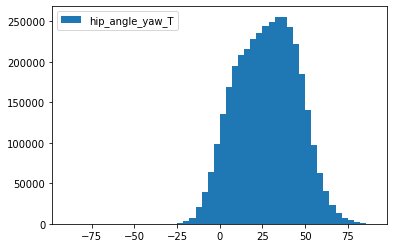

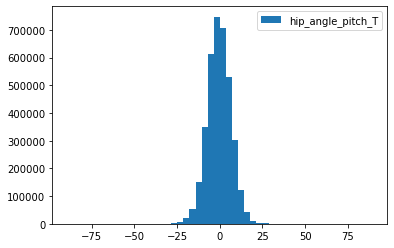

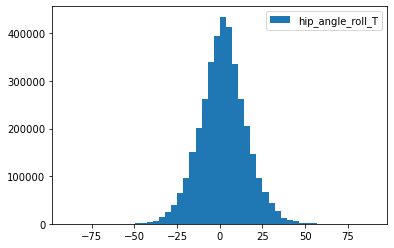

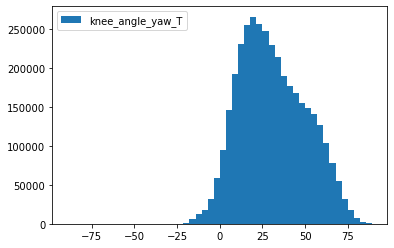

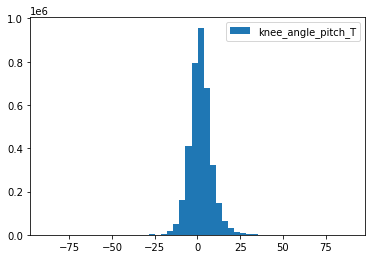

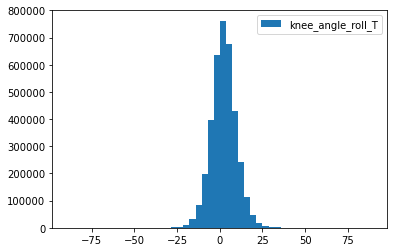

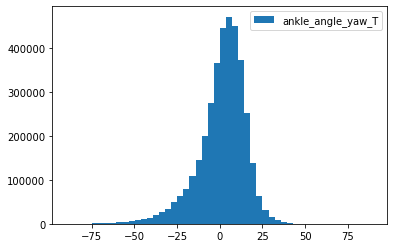

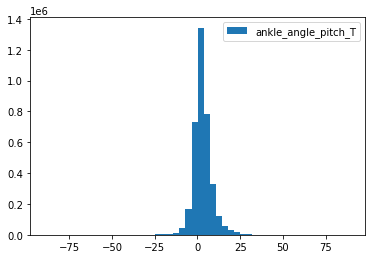

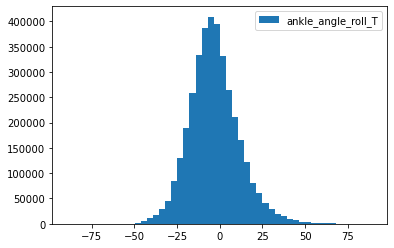

In [63]:
# Plot histogram of the data 
for f in range(len(features)):
    plt.hist(Y_train_data[:,:,f].reshape(-1,1), label = features[f], bins=50, range=(Y_train_data.min(), Y_train_data.max()))
    plt.legend()
    plt.show()

In [64]:
# Clear datasets from RAM 
X_train_windows = 1
Y_train_windows = 1 

X_val_windows = 1
Y_val_windows = 1
train_val_data = 1
val_data = 1 


### Scaling of the Data 
Data will be normalised (instead of standarization), to bound range of values between 0-1

In [65]:
# Normalisation equation = x - min(x) / max(x) - min(x)

def normalise_fit(data):
    '''
    Normalises X_train and output scales to use for normalising testing data and de-normalising output
    Args:
        prenormalised_data should be a 3-dimensional np.array 
    
    Output:
        normalised_data: np.array with the same shape as input data, but normalised
        scaling_factors: np.array with 2 rows index 0 for min_val, index 1 for max_value and nfeatures columns 

    '''
    
    if data.ndim != 3:
        raise ValueError("this function can only normalise 3-dimensional inputs")

    normalised_data = np.zeros(data.shape, dtype=np.float32) 

    features = data.shape[-1]
    scaling_factors = np.zeros((2, features))

    for feature in range(features):
        # print(feature)
        scaling_factors[0, feature], scaling_factors[1, feature] =  data[:,:,feature].min(), data[:,:,feature].max() #index 0 is for min, index 1 for max (applies to all features)
        normalised_data[:,:,feature] = (data[:,:,feature] - data[:,:,feature].min())/ (data[:,:,feature].max() - data[:,:,feature].min())

        # scaling_factors[0, feature], scaling_factors[1, feature] =  -90, 90 #index 0 is for min, index 1 for max (applies to all features)
        # normalised_data[:,:,feature] = (data[:,:,feature] - (-90))/ ((90) - (-90))

    return normalised_data, scaling_factors

In [66]:
def normalise_transform(data, scaling_factors):
    '''
    Normalise data based on the scaling factors used to normalised the training data 
    '''

    transformed_data = np.zeros(data.shape, dtype=np.float32)
    if data.shape[-1] > 1:
        for feature in range(data.shape[-1]): #loop over the number of features
            min_val = scaling_factors[0, feature] #get minimum value
            # print(f'min_val = {min_val}')
            max_val = scaling_factors[1, feature] # get maximum value 
            # print(f'max_val = {max_val}')

            transformed_data[:,:,feature] = (data[:,:,feature] - min_val) / (max_val - min_val)
    
    # in case there is one feature only where scaling_factor shape (2,1)
    else:
        min_val = scaling_factors[0]
        max_val = scaling_factors[1]
        transformed_data[:,:,0] = (data[:,:,0] - min_val) / (max_val - min_val)
    
    return transformed_data

In [67]:
# denorm_value = ((max-min) * norm_value) + min
def denormalise(data, scaling_factors):
    '''
    De-normalise data of the model
    '''
    denormalised_data = np.zeros(data.shape,  dtype=np.float32)

    for feature in range(data.shape[-1]):
        min_val = scaling_factors[0, feature]
        max_val = scaling_factors[1, feature]

        denormalised_data[:,:,feature] = ((max_val - min_val) * data[:,:,feature]) + min_val
    
    return denormalised_data

In [68]:
# Normalising data (find scalars on training data and apply the same on val and testing data)
X_train_norm, scalars = normalise_fit(X_train_data)
X_train_data = 1
Y_train_norm = normalise_transform(Y_train_data, scalars)
Y_train_data = 1

X_val_norm = normalise_transform(X_val_data, scalars)
X_val_data = 1 
Y_val_norm = normalise_transform(Y_val_data, scalars)
Y_val_data = 1 

In [69]:
scalars

array([[-39.58482742, -36.60737991, -55.66095734, -25.77786446,
        -33.52597809, -45.44993591, -89.03847504, -58.5161705 ,
        -69.22824097],
       [ 89.70739746,  37.09776306,  69.19621277,  89.98672485,
         49.04060364,  89.19622803,  61.46399689,  78.19927216,
         81.34680939]])

In [70]:
scalars[1] - scalars[0]

array([129.29222488,  73.70514297, 124.8571701 , 115.76458931,
        82.56658173, 134.64616394, 150.50247192, 136.71544266,
       150.57505035])

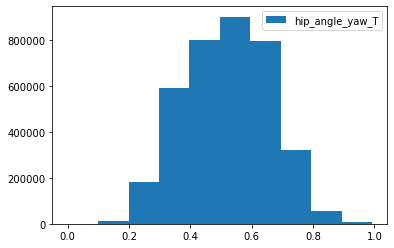

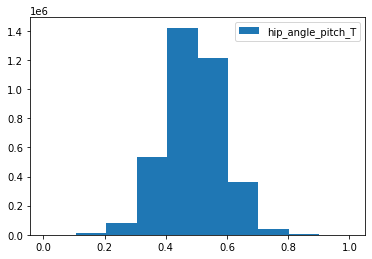

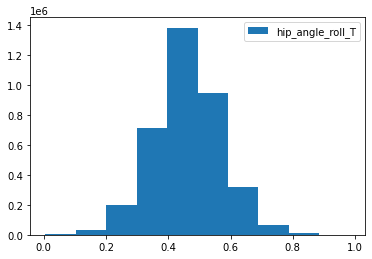

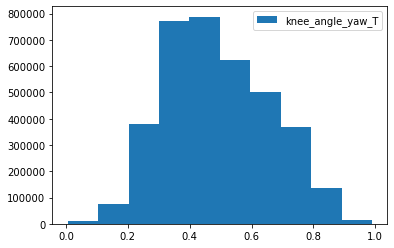

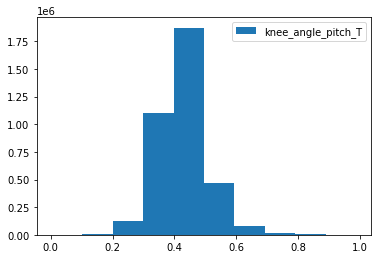

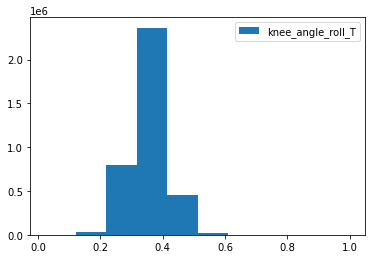

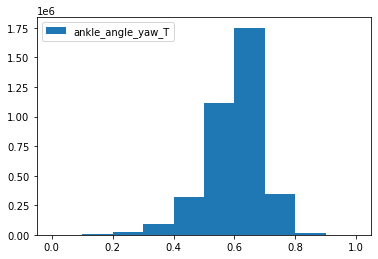

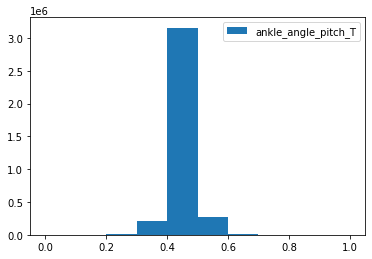

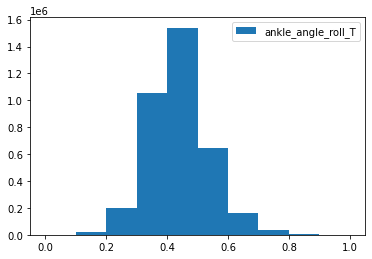

In [71]:
# Plot histogram of the data 
for f in range(len(features)):
    plt.hist(Y_train_norm[:,:,f].reshape(-1,1), label = features[f])
    plt.legend()
    plt.show()

### Scaling of Data 
Data will be normalised (instead of standarization), to bound range of values between 0-1

In [72]:
# Convert to Tensor 
# do not store on GPU (yet)
X_train = torch.from_numpy(X_train_norm).float()
Y_train = torch.from_numpy(Y_train_norm).float()

X_val = torch.from_numpy(X_val_norm).float()
Y_val = torch.from_numpy(Y_val_norm).float()

# X_test = torch.from_numpy(X_test_norm).float()
# Y_test = torch.from_numpy(Y_test_norm).float()

print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

# print(f'X_test shape: {X_test.shape}')
# print(f'Y_test shape: {Y_test.shape}')

X_train shape: torch.Size([152810, 120, 9])
Y_train shape: torch.Size([152810, 24, 9])
X_val shape: torch.Size([30840, 120, 9])
Y_val shape: torch.Size([30840, 24, 9])


### Creating Datasets using dataloaders 

In [73]:
# Creates dataset object that gets individual samples for training/testing so that the Dataloader can generate batches
class gaitDataset(Dataset):
    def __init__(self, x, y):
        self.x = x 
        self.y = y 

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        X_sample = self.x[index, :, :]
        Y_sample = self.y[index, :, :]
        return X_sample, Y_sample

In [74]:
train_dataset = gaitDataset(X_train, Y_train)
# train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle = False)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle = True, num_workers=0)

val_dataset = gaitDataset(X_val, Y_val) #ADJUSTED
# val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)

# test_dataset = gaitDataset(X_test, Y_test)
# # test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print(f"Train Dataset length: {len(train_dataset)}")
print(f"Val Dataset length: {len(val_dataset)}")
# print(f"Test Dataset length: {len(test_dataset)}")

Train Dataset length: 152810
Val Dataset length: 30840


In [75]:
# Test Dataloader (Iterate through samples)
train_sample_X, train_sample_Y = next(iter(train_dataloader))

print(f"Feature batch shape: {train_sample_X.size()}")
print(f"Labels batch shape: {train_sample_Y.size()}")

Feature batch shape: torch.Size([32, 120, 9])
Labels batch shape: torch.Size([32, 24, 9])


### MLP Model 

In [76]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, in_seq_len, out_seq_len, device):
        super(MLP, self).__init__()
        # self.flatten = nn.Flatten()
        self.input_size = input_size
        self.output_size = output_size
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.device = device 
        self.layers = 3
        self.num_units = 200
        

        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

        # self.MLP = nn.Sequential(
        #     nn.Linear(in_features=self.input_size*self.in_seq_len , out_features=200),
        #     nn.ReLU(),
        #     nn.Linear(200, 200),
        #     nn.ReLU(),
        #     nn.Linear(200, 200),
        #     nn.ReLU(),
        #     nn.Linear(200, self.output_size*self.out_seq_len),
        # )

        linear_layers_lst = [] #linear layer list
 
        for i in range(self.layers):
            linear_layers_lst.append(nn.Linear(self.num_units, self.num_units))
            linear_layers_lst.append(nn.ReLU())

       
        linear_layers = tuple((linear_layers_lst))

        self.MLP = nn.Sequential(nn.Linear(in_features=self.input_size*self.in_seq_len, out_features=self.num_units), 
                                nn.ReLU(), 
                                *linear_layers, 
                                nn.Linear(self.num_units, self.output_size*self.out_seq_len))

    def forward(self, x):
        # print(f'shape of x: {x.shape}')
        out = self.flatten(x)
        # x is in the shape [batch_size, in_seq_len, features], but should be reshaped to [batch_size, in_seq_len*features]
        # print(f'shape of flatten: {out.shape}')
        out = self.MLP(out)
        # print(f'shape of MLP: {out.shape}')
        preds = out.reshape(x.shape[0],  self.out_seq_len,self.output_size)
        return preds



In [77]:
# Training the MLP model using a loss function and a optimiser
def train_MLP(model, train_dataloader, val_dataloader, num_epochs, learning_rate):
    loss_function = nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # train_loss, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in tqdm(range(num_epochs)):
        # Loop over batch values 
        runningLoss_train = 0. 

        for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            
            # Save batch on GPU
            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            # Means we are training the model, so uses techniques such as dropout etc., otherwise model.train(model=False)
            model.train() 

            #set gradients to zero
            optimiser.zero_grad()
            preds = model(batch_inputs)
            # print(f'shape of training predictions: {preds.shape}')
        
            loss = loss_function(preds, batch_targets)
            

            loss.backward()
            optimiser.step()
            runningLoss_train += loss.item()

        train_loss[epoch] = runningLoss_train / len(train_dataloader)

        print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Training loss: {runningLoss_train/len(train_dataloader)}")

        # Evaluate on validation set

        model.eval() # means we are evaluating the model, stops process such as dropout etc. 
        runningLoss_val = 0.

        with torch.no_grad(): # makes sure gradient is not stored 
            for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                
                batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
                optimiser.zero_grad() #WHY?
                preds = model(batch_inputs)
                # print(f'shape of validation predictions: {preds.shape}')

                loss = loss_function(preds, batch_targets)
                runningLoss_val += loss.item()

        val_loss[epoch] = runningLoss_val/len(val_dataloader)

        print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Validation loss: {runningLoss_val/len(val_dataloader)}")

    return train_loss, val_loss

        

In [78]:
# Testing function 
def test_MLP(model, dataloader):
    loss_function = nn.MSELoss(reduction='mean')
    model.eval()
    actual_output, pred_output = [], []
    running_loss = 0. 
    
    with torch.no_grad():
        for idx, (batch_inputs, batch_targets) in tqdm(enumerate(dataloader)):

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            # if idx==0:
            #     batch_preds = model(batch_inputs)
            #     # print(f'batch shape: {batch_preds.shape}')
            #     loss = loss_function(batch_preds, batch_targets)
            #     running_loss += loss.item()
            #     current_preds = batch_preds
            #     all_preds = batch_preds

            # else:
            #     batch_preds = model(batch_inputs)
            #     print(f'batch shape: {batch_preds.shape}')
            #     loss = loss_function(batch_preds, batch_targets)
            #     running_loss += loss.item()
            #     all_preds = torch.cat((current_preds, batch_preds), dim=0)
            #     current_preds = batch_preds

            batch_preds = model(batch_inputs)
            loss = loss_function(batch_preds, batch_targets)
            running_loss += loss.item()
            actual_output.append(batch_targets)
            pred_output.append(batch_preds)


            #             lst = []
            # print(f'{x.size()}')
            # for i in range(10):
            #     x += i  # say we do something with x at iteration i
            #     lst.append(x)
            # # lstt = torch.stack([x for _ in range(10)])
            # lstt = torch.stack(lst)
            # print(lstt.size())

        total_loss = running_loss / len(dataloader)

        actual_output_tensor = torch.vstack(actual_output)
        pred_output_tensor = torch.vstack(pred_output)
    
    return pred_output_tensor, actual_output_tensor, total_loss

#### Run Model

In [79]:
# Set model hyperparameters 
# Train MLP
input_size=len(features)
in_seq_len=input_window
out_seq_len=output_window
output_size=len(features)
num_epochs=180
learning_rate=0.0001

model_MLP = MLP(input_size=input_size, in_seq_len=in_seq_len, out_seq_len=out_seq_len, output_size=output_size, device=DEVICE).to(DEVICE)

train_history, val_history = train_MLP(model_MLP, train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_epochs=num_epochs, learning_rate=learning_rate)

  0%|          | 0/180 [00:00<?, ?it/s]

Epoch: [1/180] Training loss: 0.006423603028320892
Epoch: [1/180] Validation loss: 0.0027113014656308405
Epoch: [2/180] Training loss: 0.002069788703422329
Epoch: [2/180] Validation loss: 0.001798749657051205


KeyboardInterrupt: 

### LSTM model

#### Desinging Model Architecture

In [80]:
# # useful resources: https://www.youtube.com/watch?v=8A6TEjG2DNw (LSTM Time Series Prediction Tutorial using PyTorch in Python | Coronavirus Daily Cases Forecasting)
# LSTM model 
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, in_seq_len, out_seq_len, output_size, device):
        super(LSTM, self).__init__()
        '''
        nn.lstm: 
        input_size = number of features in input, if batch_first = TRUE (batchSize, seq_len, Hin) FEATURES
        hidden_size = number of features in hidden state
        num_layers
        batch_first = if TRUE (batch, seq, Hin) Hin may mean input features
        h_0 = (D * num_layers, batchSize, Hout)
        c_0 = (D * num_layers, batchSize, Hcell)

        output = (batchSize, seq_len, D * Hout) Hout may mean output features, if batch first = TRUE 
        h_0 = (D*num_layers, N, Hout) final state for each element in the batch 
        C_0 = (D*num_layers, N, Hcell) final cell state for each element 

        nn.linear:
        input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
        output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 

        '''
        # Pytorch documentation: 
        # >>> rnn = nn.LSTM(10, 20, 2) features, hidden_size, number of layers 
        # >>> input = torch.randn(5, 3, 10) in_seq_len, batch_size, hidden_size (batch size should not be input to the mode, inferred from the shape of the input and will be the first number if batch_first = TRUE)
        # >>> h0 = torch.randn(2, 3, 20)
        # >>> c0 = torch.randn(2, 3, 20)
        # >>> output, (hn, cn) = rnn(input, (h0, c0))

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.in_seq_len = in_seq_len
        self.output_size = output_size
        self.out_seq_len = out_seq_len
        self.device = device
        
        # nn.LSTM(features, hidden_size, number of layers)
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first = True)

        #nn.fc1
        self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))

    def forward(self, input_data):

        # initialise hidden and cell states after passing through each batch (this is skipped in stateless model)
        h_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).to(self.device) # input_data.shape[0] is equal to batch size
        c_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).to(self.device)

        # propagate through LSTM
        lstm_out, (h_out, c_out) = self.lstm(input_data, (h_0, c_0))
        # lsmt_out.shape = (batch_size,seq_length, hidden_size)
        # print(f'lsmt_out: {lstm_out.shape}')
        # print(f'h_out: {h_out[-1].shape}')

        # propagate through linear layer 
        fc1_out = self.fc1(h_out[-1])
        # print(f'preds.shape (before reshaping): {fc1_out.shape}')
        
        preds = fc1_out.reshape(input_data.shape[0], self.out_seq_len, self.output_size)
        # print(f'preds.shape (after reshaping): {preds.shape}')

        return preds

In [81]:
# # Training the LSTM model using a loss function and a optimiser
# def train_LSTM(model, train_dataloader, val_dataloader, num_epochs, learning_rate):
#     loss_function = nn.MSELoss(reduction='mean')
#     optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)

#     # train_loss, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)
#     train_loss = np.zeros(num_epochs)
#     val_loss = np.zeros(num_epochs)

#     for epoch in tqdm(range(num_epochs)):
#         # Loop over batch values 
#         runningLoss_train = 0. 

#         for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            
#             # Save batch on GPU
#             batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

#             # Means we are training the model, so uses techniques such as dropout etc., otherwise model.train(model=False)
#             model.train() 

#             #set gradients to zero
#             optimiser.zero_grad()
#             preds = model(batch_inputs)
#             # print(f'shape of training predictions: {preds.shape}')
        
#             loss = loss_function(preds, batch_targets)
            

#             loss.backward()
#             optimiser.step()
#             runningLoss_train += loss.item()

#         train_loss[epoch] = runningLoss_train / len(train_dataloader)

#         print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Training loss: {runningLoss_train/len(train_dataloader)}")

#         # Evaluate on validation set

#         model.eval() # means we are evaluating the model, stops process such as dropout etc. 
#         runningLoss_val = 0.

#         with torch.no_grad(): # makes sure gradient is not stored 
#             for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                
#                 batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
#                 optimiser.zero_grad() #WHY?
#                 preds = model(batch_inputs)
#                 # print(f'shape of validation predictions: {preds.shape}')

#                 loss = loss_function(preds, batch_targets)
#                 runningLoss_val += loss.item()

#         val_loss[epoch] = runningLoss_val/len(val_dataloader)

#         print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Validation loss: {runningLoss_val/len(val_dataloader)}")

#     return train_loss, val_loss

        

#### Test LSTM

In [82]:
# Testing function 
def test_LSTM(model, dataloader):
    loss_function = nn.MSELoss(reduction='mean')
    model.eval()
    actual_output, pred_output = [], []
    running_loss = 0. 
    
    with torch.no_grad():
        for idx, (batch_inputs, batch_targets) in tqdm(enumerate(dataloader)):

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            # if idx==0:
            #     batch_preds = model(batch_inputs)
            #     # print(f'batch shape: {batch_preds.shape}')
            #     loss = loss_function(batch_preds, batch_targets)
            #     running_loss += loss.item()
            #     current_preds = batch_preds
            #     all_preds = batch_preds

            # else:
            #     batch_preds = model(batch_inputs)
            #     print(f'batch shape: {batch_preds.shape}')
            #     loss = loss_function(batch_preds, batch_targets)
            #     running_loss += loss.item()
            #     all_preds = torch.cat((current_preds, batch_preds), dim=0)
            #     current_preds = batch_preds

            batch_preds = model(batch_inputs)
            loss = loss_function(batch_preds, batch_targets)
            running_loss += loss.item()
            actual_output.append(batch_targets)
            pred_output.append(batch_preds)


            #             lst = []
            # print(f'{x.size()}')
            # for i in range(10):
            #     x += i  # say we do something with x at iteration i
            #     lst.append(x)
            # # lstt = torch.stack([x for _ in range(10)])
            # lstt = torch.stack(lst)
            # print(lstt.size())

        total_loss = running_loss / len(dataloader)

        actual_output_tensor = torch.vstack(actual_output)
        pred_output_tensor = torch.vstack(pred_output)
    
    return pred_output_tensor, actual_output_tensor, total_loss

#### Run model

In [83]:
# # # Set model hyperparameters 
# # # Train LSTM 
# input_size=len(features)
# hidden_size=128
# num_layers=4
# in_seq_len=input_window
# out_seq_len=output_window
# output_size=len(features)
# num_epochs=60

# # learning_rate= 0.001

# # model_LSTM = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, in_seq_len=in_seq_len, out_seq_len=out_seq_len, output_size=output_size, device=DEVICE).to(DEVICE)


# # train_history, val_history = train_LSTM(model_LSTM, train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_epochs=num_epochs, learning_rate=learning_rate) #ADJUSTED

In [84]:
# for p in model_LSTM.parameters():
#     print(p.device)

In [85]:
# !python -m torch.utils.collect_env

### CNN

#### Design Model Architecture

In [86]:
# # commented on 3.1.2022
# class CNN(nn.Module):
#     def __init__(self, input_size, output_size, kernel_size, stride, in_seq_len, out_seq_len, device=DEVICE):
#         super(CNN, self).__init__()
#         '''
#         nn.Conv1d
#         in_channels: number of features in input 
#         out_channels: number of channels in output
#         kernel_size: size of convolving layer
#         stride: convolution stride
#         padding=0
#         dilation=1
#         groups=1
#         bias=True
#         padding_mode='zeros'
#         device=device 
#         dtype=None

#         nn.MaxPool1d
#         kernel_size:
#         stride=None: default is kernel_size
#         padding=0:
#         dilation=1
#         return_indices=False
#         ceil_mode=False

#         torch.flatten (reshapes to 1D vector)
#         input
#         start_dim=0
#         end_dim=- 1

#         nn.Linear 
#         input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
#         output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 
#         '''
#         # Pytorch documentation: 
#         # >>> m = nn.Conv1d(16, 33, 3, stride=2) features(in_channels), output_channels, kernel_size
#         # >>> input = torch.randn(20, 16, 50) batch_size, features, length of sequence 
#         # >>> output = m(input~)


#         # >>> m = nn.MaxPool1d(3, stride=2) kernel_size, stride
#         # >>> input = torch.randn(20, 16, 50)
#         # >>> output = m(input)
    
#         self.input_size = input_size
#         self.output_size = output_size
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.device = device 
#         self.in_seq_len = in_seq_len
#         self.out_seq_len = out_seq_len

#         self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = 256, kernel_size = 5, stride = self.stride, padding = 5)
#         # self.batchnorm1 = nn.BatchNorm1d(16)
#         self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
#         self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size = 5, stride = self.stride, padding = 5)
#         # self.batchnorm2 = nn.BatchNorm1d(32)
#         self.pool2 = nn.MaxPool1d(kernel_size=2,stride=2)
#         self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size = 5, stride = self.stride, padding = 5)
#         # self.batchnorm3 = nn.BatchNorm1d(64)
#         self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(in_features = 512, out_features=360)
#         # self.dropout1 = nn.Dropout(p=0.5)
#         self.fc2 = nn.Linear(in_features = 360, out_features=(self.output_size * out_seq_len))
#         # self.dropout2 = nn.Dropout(p=0.5)
#         #nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))

#     def forward(self, input_data):
#         '''
#         input_data.shape = 
#         '''
#         # print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
#         out = self.conv1(input_data)
#         out = F.relu(out)
#         # out = self.batchnorm1(out)
#         # print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
#         out = self.pool1(out)
#         # print(f'pool1 out shape = {out.shape}')
#         out = self.conv2(out)
#         # print(f'conv2 out shape: {out.shape}')
#         out = F.relu(out)
#         # out = self.batchnorm2(out)
#         out = self.pool2(out)
#         # print(f'pool2 out shape = {out.shape}')
#         out = self.conv3(out)
#         out = F.relu(out)
#         # out = self.batchnorm3(out)
#         # print(f'conv3 out shape = {out.shape}')
#         out = self.pool3(out)
#         # print(f'pool3 out shape = {out.shape}')
#         out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
#         # print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
#         out = self.fc1(out)
#         # out = self.dropout1(out)
#         # print(f'fc1 out shape: {out.shape}')
#         out = self.fc2(out)
#         # out = self.dropout2(out)
#         # print(f'fc2 out shape = {out.shape}')
#         preds = out.reshape(input_data.shape[0], self.output_size, self.out_seq_len)
#         # print(f'preds.shape (after reshaping): {preds.shape}')

#         return preds
        

#         #desired output shape [batch_size, features (out_channels), out_seq_length ]


In [87]:
# class CNN(nn.Module):
#     def __init__(self, input_size, output_size, in_seq_len, out_seq_len, device=DEVICE):
#         super(CNN, self).__init__()
#         '''
#         nn.Conv1d
#         in_channels: number of features in input 
#         out_channels: number of channels in output
#         kernel_size: size of convolving layer
#         stride: convolution stride
#         padding=0
#         dilation=1
#         groups=1
#         bias=True
#         padding_mode='zeros'
#         device=device 
#         dtype=None

#         nn.MaxPool1d
#         kernel_size:
#         stride=None: default is kernel_size
#         padding=0:
#         dilation=1
#         return_indices=False
#         ceil_mode=False

#         torch.flatten (reshapes to 1D vector)
#         input
#         start_dim=0
#         end_dim=- 1

#         nn.Linear 
#         input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
#         output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 
#         '''
#         # Pytorch documentation: 
#         # >>> m = nn.Conv1d(16, 33, 3, stride=2) features(in_channels), output_channels, kernel_size
#         # >>> input = torch.randn(20, 16, 50) batch_size, features, length of sequence 
#         # >>> output = m(input~)


#         # >>> m = nn.MaxPool1d(3, stride=2) kernel_size, stride
#         # >>> input = torch.randn(20, 16, 50)
#         # >>> output = m(input)
    
#         self.input_size = input_size
#         self.output_size = output_size
#         # self.kernel_size = kernel_size
#         # self.stride = stride
#         self.device = device 
#         self.in_seq_len = in_seq_len
#         self.out_seq_len = out_seq_len
#         self.conv1_channels = 32
#         self.conv2_channels = 32
#         self.conv3_channels = 256
#         self.conv4_channels = 512
#         self.kernel_12 = 7
#         self.kernel_34 = 5
#         self.padding = 5
#         self.stride = 1
#         self.dilation = 4

#         def calc_shape(input, kernel_size, stride, padding=0, dilation =1, operation = 'conv'):
#             if operation == 'conv':
#             # size = ((input - kernel_size + (2 * padding))/stride)  + 1 
#                 size = ((input + 2 * padding - dilation * (kernel_size-1) -1)/stride )+ 1

#             if operation == 'pool':
#                 size = ((input - kernel_size)/stride)  + 1

#             return size

#         self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = self.conv1_channels, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding, dilation=self.dilation)
#         post_conv1 = calc_shape(input = self.in_seq_len, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
#         # print(f'post conv1: {post_conv1}')

#         self.conv2 = nn.Conv1d(in_channels = self.conv1_channels, out_channels = self.conv2_channels, kernel_size = self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation)
#         post_conv2 = calc_shape(input = post_conv1, kernel_size =self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation,  operation='conv')
#         # print(f'post conv2: {post_conv2}')

#         self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
#         post_pool1 = calc_shape(input = post_conv2, kernel_size = 2, stride = 2,  operation='pool')
#         # print(f'post poo1: {post_pool1}')

#         self.conv3 = nn.Conv1d(in_channels=self.conv2_channels, out_channels=self.conv3_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation )
#         post_conv3 = calc_shape(input = post_pool1, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding, dilation=self.dilation, operation='conv')
#         # print(f'post conv3: {post_conv3}')


#         self.conv4 = nn.Conv1d(in_channels=self.conv3_channels, out_channels=self.conv4_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation)
#         post_conv4 = calc_shape(input = post_conv3, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
#         # print(f'post conv4: {post_conv4}')


#         self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
#         post_pool2 = calc_shape(input = post_conv4, kernel_size = 2, stride = 2,  operation='pool')
#         # print(f'post pool2: {post_pool2}')

#         # print(f'linear input: {post_pool2 * 32}')

#         self.fc1 = nn.Linear(in_features = (int(post_pool2) * self.conv4_channels), out_features=(self.output_size * out_seq_len))
#         #nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))


#     def forward(self, input_data):
#         '''
#         input_data.shape = 
#         '''
#         # print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
#         out = self.conv1(input_data)
#         out = F.relu(out)
#         out = self.conv2(out)
#         out = F.relu(out)
#         # print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
#         out = self.pool1(out)
#         # print(f'pool1 out shape = {out.shape}')
#         out = self.conv3(out)
#         # print(f'conv2 out shape: {out.shape}')
#         out = F.relu(out)
#         out = self.conv4(out)
#         out = F.relu(out)
#         out = self.pool2(out)
#         out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
#         # print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
#         out = self.fc1(out)
#         # print(f'fc1 out shape: {out.shape}')
#         preds = out.reshape(input_data.shape[0], self.output_size, self.out_seq_len)
#         # print(f'preds.shape (after reshaping): {preds.shape}')

#         return preds
        

In [88]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size, in_seq_len, out_seq_len, device=DEVICE):
        super(CNN, self).__init__()
        '''
        nn.Conv1d
        in_channels: number of features in input 
        out_channels: number of channels in output
        kernel_size: size of convolving layer
        stride: convolution stride
        padding=0
        dilation=1
        groups=1
        bias=True
        padding_mode='zeros'
        device=device 
        dtype=None

        nn.MaxPool1d
        kernel_size:
        stride=None: default is kernel_size
        padding=0:
        dilation=1
        return_indices=False
        ceil_mode=False

        torch.flatten (reshapes to 1D vector)
        input
        start_dim=0
        end_dim=- 1

        nn.Linear 
        input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
        output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 
        '''
        # Pytorch documentation: 
        # >>> m = nn.Conv1d(16, 33, 3, stride=2) features(in_channels), output_channels, kernel_size
        # >>> input = torch.randn(20, 16, 50) batch_size, features, length of sequence 
        # >>> output = m(input~)


        # >>> m = nn.MaxPool1d(3, stride=2) kernel_size, stride
        # >>> input = torch.randn(20, 16, 50)
        # >>> output = m(input)
    
        self.input_size = input_size
        self.output_size = output_size
        # self.kernel_size = kernel_size
        # self.stride = stride
        self.device = device 
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.conv1_channels = 32
        self.conv2_channels = 48
        self.conv3_channels = 256
        self.conv4_channels = 512
        self.kernel_12 = 7
        self.kernel_34 = 7
        self.padding = 4
        self.stride = 1
        self.dilation = 1

        def calc_shape(input, kernel_size, stride, padding=0, dilation =1, operation = 'conv'):
            if operation == 'conv':
            # size = ((input - kernel_size + (2 * padding))/stride)  + 1 
                size = ((input + 2 * padding - dilation * (kernel_size-1) -1)/stride )+ 1

            if operation == 'pool':
                size = ((input - kernel_size)/stride)  + 1

            return size

        self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = self.conv1_channels, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding, dilation=self.dilation)
        post_conv1 = calc_shape(input = self.in_seq_len, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv1: {post_conv1}')

        self.conv2 = nn.Conv1d(in_channels = self.conv1_channels, out_channels = self.conv2_channels, kernel_size = self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv2 = calc_shape(input = post_conv1, kernel_size =self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation,  operation='conv')
        # print(f'post conv2: {post_conv2}')

        self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool1 = calc_shape(input = post_conv2, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post poo1: {post_pool1}')

        self.conv3 = nn.Conv1d(in_channels=self.conv2_channels, out_channels=self.conv3_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation )
        post_conv3 = calc_shape(input = post_pool1, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding, dilation=self.dilation, operation='conv')
        # print(f'post conv3: {post_conv3}')


        self.conv4 = nn.Conv1d(in_channels=self.conv3_channels, out_channels=self.conv4_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv4 = calc_shape(input = post_conv3, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv4: {post_conv4}')


        self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool2 = calc_shape(input = post_conv4, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post pool2: {post_pool2}')

        # print(f'linear input: {post_pool2 * 32}')

        self.fc1 = nn.Linear(in_features = (int(post_pool2) * self.conv4_channels), out_features=(self.output_size * out_seq_len))
        #nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))


    def forward(self, input_data):
        '''
        input_data.shape = 
        '''
        # print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
        out = self.conv1(input_data)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        # print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
        out = self.pool1(out)
        # print(f'pool1 out shape = {out.shape}')
        out = self.conv3(out)
        # print(f'conv2 out shape: {out.shape}')
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
        # print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
        out = self.fc1(out)
        # print(f'fc1 out shape: {out.shape}')
        preds = out.reshape(input_data.shape[0], self.output_size, self.out_seq_len)
        # print(f'preds.shape (after reshaping): {preds.shape}')

        return preds
        

In [89]:

# class CNN(nn.Module):
#     def __init__(self, input_size, output_size, kernel_size, stride, in_seq_len, out_seq_len, device=DEVICE):
#         super(CNN, self).__init__()
#         '''
#         nn.Conv1d
#         in_channels: number of features in input 
#         out_channels: number of channels in output
#         kernel_size: size of convolving layer
#         stride: convolution stride
#         padding=0
#         dilation=1
#         groups=1
#         bias=True
#         padding_mode='zeros'
#         device=device 
#         dtype=None

#         nn.MaxPool1d
#         kernel_size:
#         stride=None: default is kernel_size
#         padding=0:
#         dilation=1
#         return_indices=False
#         ceil_mode=False

#         torch.flatten (reshapes to 1D vector)
#         input
#         start_dim=0
#         end_dim=- 1

#         nn.Linear 
#         input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
#         output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 
#         '''
#         # Pytorch documentation: 
#         # >>> m = nn.Conv1d(16, 33, 3, stride=2) features(in_channels), output_channels, kernel_size
#         # >>> input = torch.randn(20, 16, 50) batch_size, features, length of sequence 
#         # >>> output = m(input~)


#         # >>> m = nn.MaxPool1d(3, stride=2) kernel_size, stride
#         # >>> input = torch.randn(20, 16, 50)
#         # >>> output = m(input)
    
#         self.input_size = input_size
#         self.output_size = output_size
#         # self.kernel_size = kernel_size
#         self.stride = stride
#         self.device = device 
#         self.in_seq_len = in_seq_len
#         self.out_seq_len = out_seq_len

#         self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = 64, kernel_size = 7, stride = self.stride, padding = 5)
#         self.conv2 = nn.Conv1d(in_channels = 64, out_channels = 48, kernel_size = 7, stride = self.stride, padding = 5)
#         self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
#         self.conv3 = nn.Conv1d(in_channels=48, out_channels=32, kernel_size = 5, stride = self.stride, padding = 5)
#         self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size = 5, stride = self.stride, padding = 5)
#         self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
#         self.fc1 = nn.Linear(in_features = 1024, out_features=(self.output_size * out_seq_len))
#         #nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))

#     def forward(self, input_data):
#         '''
#         input_data.shape = 
#         '''
#         # print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
#         out = self.conv1(input_data)
#         out = F.relu(out)
#         out = self.conv2(out)
#         out = F.relu(out)
#         # print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
#         out = self.pool1(out)
#         # print(f'pool1 out shape = {out.shape}')
#         out = self.conv3(out)
#         # print(f'conv2 out shape: {out.shape}')
#         out = F.relu(out)
#         out = self.conv4(out)
#         out = F.relu(out)
#         out = self.pool2(out)
#         out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
#         # print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
#         out = self.fc1(out)
#         # print(f'fc1 out shape: {out.shape}')
#         preds = out.reshape(input_data.shape[0], self.output_size, self.out_seq_len)
#         # print(f'preds.shape (after reshaping): {preds.shape}')

#         return preds
        

#### Training and validating CNN

In [90]:
# # Training the CNN model using a loss function and a optimiser
# def train_CNN(model, train_dataloader, val_dataloader, num_epochs, learning_rate):
#     loss_function = nn.MSELoss(reduction='mean')
    
#     # loss2_fun = nn.MSELoss(reduction="mean")
#     optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)

#     # train_loss, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)
#     train_loss = np.zeros(num_epochs)
#     val_loss = np.zeros(num_epochs)

#     for epoch in tqdm(range(num_epochs)):
#         # Loop over batch values 
#         runningLoss_train = 0. 

#         for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            
#             # Save batch on GPU
#             batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

#             # Means we are training the model, so uses techniques such as dropout etc., otherwise model.train(model=False)
#             model.train() 

#             #set gradients to zero
#             optimiser.zero_grad()
#             preds = model(batch_inputs.permute(0,2,1))
#             # print(f'shape of training predictions: {preds.shape}')
        
#             loss = loss_function(preds, batch_targets.permute(0,2,1))
#             # loss_manual = mse_loss(preds, batch_targets.permute(0,2,1), reduction='mean')
#             # print(f'preds shape: {preds.shape}')
#             # print(f'targets shape: {batch_targets.permute(0,2,1).shape}')
#             # print(f'loss automatic: {loss.item()}')
#             # print(f'loss manual: {loss_manual}')            

#             loss.backward()
#             optimiser.step()
#             runningLoss_train += loss.item()

#         train_loss[epoch] = runningLoss_train / len(train_dataloader)

#         print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Training loss: {runningLoss_train/len(train_dataloader)}")

#         # Evaluate on validation set

#         model.eval() # means we are evaluating the model, stops process such as dropout etc. 
#         runningLoss_val = 0.

#         with torch.no_grad(): # makes sure gradient is not stored 
#             for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                
#                 batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
#                 optimiser.zero_grad() #WHY?
#                 preds = model(batch_inputs.permute(0,2,1)) # permute to make the input shape (samples, features, input_window_size)
#                 # print(f'shape of validation predictions: {preds.shape}')

#                 loss = loss_function(preds, batch_targets.permute(0,2,1)) #permute targets to make it same shape as preds
#                 runningLoss_val += loss.item()

#         val_loss[epoch] = runningLoss_val/len(val_dataloader)

#         print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Validation loss: {runningLoss_val/len(val_dataloader)}")

#     return train_loss, val_loss

In [91]:
# Testing function 
def test_CNN(model, dataloader):
    loss_function = nn.MSELoss(reduction='mean')
    model.eval()
    actual_output, pred_output = [], []
    running_loss = 0. 
    
    with torch.no_grad():
        for idx, (batch_inputs, batch_targets) in tqdm(enumerate(dataloader)):

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

            batch_preds = model(batch_inputs.permute(0,2,1))
            loss = loss_function(batch_preds, batch_targets.permute(0,2,1))
            running_loss += loss.item()
            actual_output.append(batch_targets.permute(0,2,1))
            # print(f'actual_output_shape:{batch_targets.permute(0,2,1).shape}')
       
            pred_output.append(batch_preds)
            # print(f'pred_output shape; {batch_preds.shape}')

        total_loss = running_loss / len(dataloader)

        actual_output_tensor = torch.vstack(actual_output)
        pred_output_tensor = torch.vstack(pred_output)
    
    return pred_output_tensor.permute(0,2,1), actual_output_tensor.permute(0,2,1), total_loss

In [92]:
# # Set model hyperparameters 
# # Train CNN
# input_size=len(features)
# in_seq_len=input_window
# out_seq_len=output_window
# # kernel_size=1
# num_epochs=150
# learning_rate=0.0001
# output_size = len(features)

In [93]:
# model_CNN = CNN(input_size, output_size=output_size, in_seq_len=in_seq_len, out_seq_len=out_seq_len,  device = DEVICE).to(DEVICE)

# train_history, val_history = train_CNN(model_CNN, train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_epochs=num_epochs, learning_rate=learning_rate)

### Hybrid CNN-LSTM 


In [94]:
# class hybrid(nn.Module):
#     def __init__(self, input_size, output_size, hidden_size, num_layers, stride, padding, in_seq_len, out_seq_len, device=DEVICE):
#         super(hybrid, self).__init__()

#         self.input_size = input_size
#         self.output_size = output_size
#         self.stride = stride
#         self.padding = padding 
#         self.device = device 
#         self.in_seq_len = in_seq_len
#         self.out_seq_len = out_seq_len
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = 48, kernel_size = 7, stride = self.stride, padding = self.padding)
#         self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
#         self.conv2 = nn.Conv1d(in_channels=48, out_channels=32, kernel_size = 5, stride = self.stride, padding = self.padding)
#         self.fc1 = nn.Linear(in_features = 1696, out_features=(self.output_size * in_seq_len))
#         self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first = True)
#         self.fc2 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))

#         '''
#         input shape for CNN: [samples, features, in_seq_len]
#         output shape for CNN: [samples,out_seq_len, features]

#         input shape for LSTM: [samples,out_seq_len, features]
#         output shape for LSTM: [samples,out_seq_len, features]
#         '''
#     def forward(self, input_data):
     
#         print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
#         out = self.conv1(input_data)
#         out = F.relu(out)
#         print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
#         out = self.pool1(out)
#         print(f'pool1 out shape = {out.shape}')
#         out = self.conv2(out)
#         print(f'conv2 out shape: {out.shape}')
#         out = F.relu(out)
#         out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
#         print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
#         out = self.fc1(out)
#         print(f'fc1 out shape: {out.shape}')
#         print(f'reshaped output: {out.reshape(input_data.shape[0], self.in_seq_len, self.output_size).shape}')
        
#         h_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).to(self.device) # input_data.shape[0] is equal to batch size
#         c_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).to(self.device)

#         lstm, (h_out, c_out) = self.lstm(out.reshape(input_data.shape[0], self.in_seq_len, self.output_size), (h_0, c_0))
#         out = self.fc2(h_out[-1])

#         preds = out.reshape(input_data.shape[0], self.out_seq_len, self.output_size)

#         return preds
        

In [95]:
# # Training the CNN model using a loss function and a optimiser
# def train_hybrid(model, train_dataloader, val_dataloader, num_epochs, learning_rate):
#     loss_function = nn.MSELoss(reduction='mean')
    
#     # loss2_fun = nn.MSELoss(reduction="mean")
#     optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)

#     # train_loss, val_loss = np.zeros(num_epochs), np.zeros(num_epochs)
#     train_loss = np.zeros(num_epochs)
#     val_loss = np.zeros(num_epochs)

#     for epoch in tqdm(range(num_epochs)):
#         # Loop over batch values 
#         runningLoss_train = 0. 

#         for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            
#             # Save batch on GPU
#             batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

#             # Means we are training the model, so uses techniques such as dropout etc., otherwise model.train(model=False)
#             model.train() 

#             #set gradients to zero
#             optimiser.zero_grad()
#             preds = model(batch_inputs.permute(0,2,1))
#             # print(f'shape of training predictions: {preds.shape}')
        
#             loss = loss_function(preds, batch_targets)
#             # loss_manual = mse_loss(preds, batch_targets.permute(0,2,1), reduction='mean')
#             # print(f'preds shape: {preds.shape}')
#             # print(f'targets shape: {batch_targets.permute(0,2,1).shape}')
#             # print(f'loss automatic: {loss.item()}')
#             # print(f'loss manual: {loss_manual}')            

#             loss.backward()
#             optimiser.step()
#             runningLoss_train += loss.item()

#         train_loss[epoch] = runningLoss_train / len(train_dataloader)

#         print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Training loss: {runningLoss_train/len(train_dataloader):.4f}")

#         # Evaluate on validation set

#         model.eval() # means we are evaluating the model, stops process such as dropout etc. 
#         runningLoss_val = 0.

#         with torch.no_grad(): # makes sure gradient is not stored 
#             for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                
#                 batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
#                 optimiser.zero_grad() #WHY?
#                 preds = model(batch_inputs.permute(0,2,1)) # permute to make the input shape (samples, features, input_window_size)
#                 # print(f'shape of validation predictions: {preds.shape}')

#                 loss = loss_function(preds, batch_targets) #permute targets to make it same shape as preds
#                 runningLoss_val += loss.item()

#         val_loss[epoch] = runningLoss_val/len(val_dataloader)

#         print(f"Epoch: [{epoch + 1}/{num_epochs}]", f"Validation loss: {runningLoss_val/len(val_dataloader):.4f}")

#     return train_loss, val_loss

#### Run hybrid

In [96]:
# # Set model hyperparameters 
# # Train hybrid CNN-LSTM
# input_size=len(features)
# in_seq_len=input_window
# out_seq_len=output_window
# # kernel_size=1
# num_epochs=10
# learning_rate=1e-3
# output_size = len(features)
# hidden_size = 100
# num_layers=2

In [97]:
# model_hybrid = hybrid(input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers, stride=1, padding=0, in_seq_len=in_seq_len, out_seq_len=out_seq_len,  device = DEVICE).to(DEVICE)

# train_history, val_history = train_hybrid(model_hybrid, train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_epochs=num_epochs, learning_rate=learning_rate)

In [98]:
# # Testing function 
# def test_hybrid(model, dataloader):
#     loss_function = nn.MSELoss(reduction='mean')
#     model.eval()
#     actual_output, pred_output = [], []
#     running_loss = 0. 
    
#     with torch.no_grad():
#         for idx, (batch_inputs, batch_targets) in tqdm(enumerate(dataloader)):

#             batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)

#             batch_preds = model(batch_inputs.permute(0,2,1))
#             loss = loss_function(batch_preds, batch_targets)
#             running_loss += loss.item()
#             actual_output.append(batch_targets)
#             # print(f'actual_output_shape:{batch_targets.permute(0,2,1).shape}')
       
#             pred_output.append(batch_preds)
#             # print(f'pred_output shape; {batch_preds.shape}')

#         total_loss = running_loss / len(dataloader)

#         actual_output_tensor = torch.vstack(actual_output)
#         pred_output_tensor = torch.vstack(pred_output)
    
#     return pred_output_tensor, actual_output_tensor, total_loss

### Evaluate Performance

#### Training and Validation loss history

In [99]:
plt.plot(train_history[20:], label = 'Training loss')
plt.plot(val_history[20:], label = 'Val loss')
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.show()

NameError: name 'train_history' is not defined

In [ ]:
# b = torch.isnan(Y_train)
# torch.sum(b == True)

### Import Previously Trained Model

In [ ]:
# import_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Models\LSTM_4' + '\\' + 'Exp035-2022-02-12-LSTM-In120-Out24.pickle'
# # # import_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Models\CNN_1' + '\\' + 'Exp001-2022-01-24-CNN-In96-Out1.pickle'
# # # model_CNN = CNN(input_size, output_size=output_size, kernel_size=kernel_size, stride=1, in_seq_len=in_seq_len, out_seq_len=out_seq_len,  device = DEVICE).to(DEVICE)

# input_size=len(features)
# hidden_size=128
# num_layers=4
# in_seq_len=input_window
# out_seq_len=output_window
# output_size=len(features)
# num_epochs=60

# # learning_rate= 0.001

# model_LSTM = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, in_seq_len=in_seq_len, out_seq_len=out_seq_len, output_size=output_size, device=DEVICE).to(DEVICE)
# model_LSTM.load_state_dict(torch.load(import_path))
# model_LSTM.eval()

#### Load helper functions

In [100]:
def mse_loss(preds, targets, reduction = 'mean', format='torch'):

    
    if format == 'torch': #default option
        loss = 1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * torch.sum((targets - preds) ** 2)
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')

        # std = torch.sqrt(torch.sum((((targets - preds) ** 2) - loss)**2) * (1/preds.shape[0]*preds.shape[1]*preds.shape[2]-1))
        std = torch.std()
        
        if reduction == 'sum':
            loss = torch.sum((targets - preds) ** 2)
    
    if format == 'np':
        loss = 1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * np.sum((targets - preds) ** 2)
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')

        std = np.std(((targets - preds) ** 2).reshape(-1,1).squeeze())
        # print(np.sqrt(np.sum(((targets - preds) ** 2) - loss)**2))
        
        if reduction == 'sum':
            loss = np.sum((targets - preds) ** 2)

    return loss, std

In [101]:
#mae 
def mae_loss(preds, targets, reduction = 'mean', format='torch'):

    if format == 'torch': #default option
        loss = 1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * torch.sum(torch.abs(targets - preds))
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')
        
        if reduction == 'sum':
            loss = torch.sum(torch.abs(targets - preds))
    
    if format == 'np':
        loss = 1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * np.sum(np.absolute(targets - preds))
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')
        
        std = np.std(np.abs(targets - preds).reshape(-1,1).squeeze())

        if reduction == 'sum':
            loss = np.sum(np.absolute(targets - preds))

    return loss, std

In [102]:
# 2 ** 4
# a = np.array([[1,2,3], [2,1,2]])
# a ** 2

In [103]:
def rmse_loss(preds, targets, reduction = 'mean', format='torch'):

    
    if format == 'torch': #default option
        loss = torch.sqrt(1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * torch.sum((targets - preds) ** 2))
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')
        
        if reduction == 'sum':
            loss = torch.sum((targets - preds) ** 2)
    
    if format == 'np':
        loss = np.sqrt(1/(preds.shape[0]*preds.shape[1]*preds.shape[2]) * np.sum((targets - preds) ** 2))
        # print(f'divide shape: {preds.shape[0]*preds.shape[1]*preds.shape[2]}')
        # print(f'square sum: {torch.sum((targets - preds) ** 2)}')
        
        if reduction == 'sum':
            loss = np.sum((targets - preds) ** 2)

    return loss

In [104]:
def calc_covariance(preds, targets, features):
    #preds shape (samples, window size, features)

    all_cov = []

    for f in range(len(features)):
        p = preds[:,:,f].reshape(-1,1) #reshaping predictions
        t = targets[:,:,f].reshape(-1,1) # reshaping targets

        pmean = np.mean(p) #calculating mean for predictions and targets 
        tmean= np.mean(t)

        cov_sum = 0 
        for i in range(len(p)):
            cov_sum += (p[i]-pmean) * (t[i]-tmean)
        
        all_cov.append(cov_sum/(len(p)-1))

    return all_cov 

In [105]:
# val_mse_loss, std_mse = mse_loss(predicted_val_denorm, actual_val_denorm, reduction='mean', format='np')
# val_mae_loss, std_mae = mae_loss(predicted_val_denorm, actual_val_denorm, reduction='mean', format='np')

# print(f'Val MSE Loss: {val_mse_loss}')
# print(f'Val MSE std: {std_mse}')
# print(f'MAE Loss: {val_mae_loss}')
# print(f'MAE std: {std_mae}')

In [106]:
# test_mse_loss, std_mse = mse_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')
# test_mae_loss, std_mae = mae_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')

# print(f'Test MSE Loss: {test_mse_loss}')
# print(f'Test MSE std: {std_mse}')
# print(f'MAE Loss: {test_mae_loss}')
# print(f'MAE std: {std_mae}')

In [107]:
# mse_diff = ((predicted_val_denorm[:,:,0] - actual_val_denorm[:,:,0]) ** 2).reshape(-1,1).squeeze()
# print(mse_diff.shape)

# print(f'mse loss for validation for feature 0: {np.sum(mse_diff)/mse_diff.shape[0]}')

# print(f'minimum loss: {mse_diff.min()}')
# print(f'maximum loss: {mse_diff.max()}')
# print(f'maximum loss corresponds to (angle): {np.sqrt(mse_diff.max())}')


# auto_mse_std = np.std(mse_diff)
# print(f'Automatic MSE std: {auto_mse_std}')

# manual_mse_std = np.sqrt((1/mse_diff.shape[0]) * np.sum((mse_diff-val_mse_loss) ** 2))
# print(f'Manual MSE std: {manual_mse_std}')

# plt.hist(mse_diff, bins=200, range=(0,25))

# mse_diff.shape[0]

In [108]:
# mae_diff = (np.abs(predicted_test_denorm[:,:,:] - actual_test_denorm[:,:,:])).reshape(-1,1).squeeze()
# mae_diff_noabs = ((predicted_test_denorm[:,:,:] - actual_test_denorm[:,:,:])).reshape(-1,1).squeeze()
# print(f'mae_diff size: {mae_diff.shape[0]}') 

# mae_diff_mean = np.sum(mae_diff)/mae_diff.shape[0] 
# print(f'mae loss for validation for feature 0: {mae_diff_mean}')

# print(f'minimum loss: {mae_diff.min()}')
# print(f'maximum loss: {mae_diff.max()}')
# print(f'maximum loss corresponds to (angle): {mae_diff.max()}')


# auto_mae_std = np.std(mae_diff)
# print(f'Automatic MAE std: {auto_mae_std}')

# # manual_mae_std = np.sqrt((1/mae_diff.shape[0]) * np.sum((mae_diff-val_mae_loss) ** 2))
# manual_mae_std = np.sqrt((1/mae_diff.shape[0]) * np.sum((mae_diff-test_mae_loss)**2))
# print(f'Manual MAE std: {manual_mae_std}')


# figure(figsize=(30, 10))
# # plt.hist(mae_diff_noabs, bins=200, range=(0,mae_diff.max()))
# plt.hist(mae_diff_noabs, bins=200)
# plt.xlabel('MAE difference')
# plt.ylabel('frequency')

# mae_diff.shape[0]

# threshold = 2.37
# larger_than_mean = np.where(mae_diff>threshold)
# print(f'number of points larger than mean: {len(larger_than_mean[0])}')

# print(f'threshold: {threshold}')
# percentage = len(larger_than_mean[0])/mae_diff.shape[0] *100
# print(f'percentage of values above the threshold: {percentage}')

In [109]:
# mae_diff = (np.abs(predicted_test_denorm[:,:,:] - actual_test_denorm[:,:,:])) #find difference between actual and predicted
# print(f'Y_test_data.shape: {Y_test_data.shape}')
# print(f'mae_diff size: {mae_diff.shape}') 

# lcns = np.where(mae_diff > 60) #find locations where mae is bigger than threshold 

# lcns_index = list(zip(lcns[0], lcns[1], lcns[-1])) 
# # print(lcns)

# unique_idx = np.unique([row[0] for row in lcns_index]) #find unique samples, removing duplicates
# print(unique_idx)

# print(f'number of outliers: {len(lcns_index)}')
# print(f'length of unique outliers: {len(unique_idx)}')

# s=unique_idx[0]
# print(f'Outlier sample is: {s}')


# ##### find the file 
# # if 10 samples per file
# file_numb = s//10

# # print(f'File number is: {file_numb}')
# # file = filtered_index_test[file_numb]
# # print(f'Source of outlier: {file}')

# # for f in range(len(features)):
# #     x = np.arange(0,input_window+output_window)
# #     plt.plot(x[:input_window],X_test_data[s,:,f].reshape(-1,1), label='X_test_data')
# #     plt.plot(x[input_window:],predicted_test_denorm[s,:,f].reshape(-1,1), label='predicted_test_denorm')
# #     plt.plot(x[input_window:], actual_test_denorm[s,:,f].reshape(-1,1), label='actual_test_denorm')
# #     plt.title(str(features[f]))
# #     plt.legend()
# #     plt.show()

# # for feature in features:
# #     i = labels[feature]
# #     plt.plot(test_data[file,:1000,i], label=feature)
# #     plt.title(str(feature))
# #     plt.show()

# # # print(lcns_index[1])
# # mae_diff[176680:176682, :, 6]

# for s in range(len(unique_idx)):
#     i = unique_idx[s]
#     rng = 2
#     istart = i - rng

#     iend = i + rng

#     for f in range(len(features)):
#         plt.show() 
#         plt.title('Index of Oultier: ' + str(i))
#         plt.plot(predicted_test_denorm[istart:iend, :, f].reshape(-1,1), label = 'predicted for feature: '+ str(f))
#         plt.plot(actual_test_denorm[istart:iend, :, f].reshape(-1,1), label = 'actual for feature: ' + str(f))
#         plt.vlines(rng * output_window, ymin=0, ymax=60, label = 'outlier', colors = 'r', linestyles='-.')
#         plt.legend()


In [110]:
# for m in range(10,30):
#     # s=unique_idx[m]
#     # # print(f'Outlier sample is: {s}')


#     # ##### find the file 
#     # # if 10 samples per file
#     # file_numb = s//10

#     # # print(f'File number is: {file_numb}')
#     # file = filtered_index_test[file_numb]
#     # print(f'Source of outlier: {file}')

#     # # for f in range(len(features)):
#     # #     x = np.arange(0,input_window+output_window)
#     # #     plt.plot(x[:input_window],X_test_data[s,:,f].reshape(-1,1), label='X_test_data')
#     # #     plt.plot(x[input_window:],predicted_test_denorm[s,:,f].reshape(-1,1), label='predicted_test_denorm')
#     # #     plt.plot(x[input_window:], actual_test_denorm[s,:,f].reshape(-1,1), label='actual_test_denorm')
#     # #     plt.title(str(features[f]) + str(f))

#     # #     plt.legend()
#     # #     plt.show()

#     print(f'file: {m}')
#     print(f'leg: {np.mean(test_data[m,:,-1])}')
#     for feature in features:
#         i = labels[feature]
#         if i == 6 or i ==7:
#             plt.plot(test_data[m,:1000,i], label=feature)
#             plt.title(str(feature))
#             plt.show()
    
    

#     # ankle_yaw_roll_diff = np.sum(X_test_data[m,:,6] - X_test_data[m,:,7])
#     # print(ankle_yaw_roll_diff)


In [ ]:
# test_data[-3,:,-1]

In [ ]:
# # checking that the outlier is from the correct file
# X_value_trial, Y_value_trail = window_generator(
#             test_data[141,:,:],
#             input_window=input_window, 
#             output_window=output_window, 
#             stride=test_stride, 
#             features=features
#             )

# for f in range(len(features)):
#     x = np.arange(0,input_window+output_window)
#     plt.plot(x[:input_window],X_value_trial[1,:,f].reshape(-1,1), label='X_value_trial')
#     plt.plot(x[input_window:],Y_value_trail[1,:,f].reshape(-1,1), label='Y_value_trail')
#     plt.title(str(features[f]))
#     plt.legend()
#     plt.show()
    

In [ ]:
# np.unique([row[0] for row in lcns_index])
# [row[0] for row in lcns_index]


In [ ]:
# cov = calc_covariance(predicted_test_denorm, actual_test_denorm, features)
# cov

In [ ]:
# abs_diff = np.abs(predicted_test_denorm[:,:,1] - actual_test_denorm[:,:,1])
# print(abs_diff.shape)

# print(abs_diff.min())
# print(abs_diff.max())


# m = np.where(abs_diff > 60)

# print(f'number of samples above this threshold: {len(m[0])}')
# abs_outliers= list(zip(m[0],m[1]))
# print(abs_outliers[0][0])
# print(abs_outliers[1])

# plt.hist(abs_diff.reshape(-1,1), range=(0,10), bins=50)

In [ ]:
# random.choice(abs_outliers[0])

# len(abs_outliers)

In [ ]:
# plt.plot(predicted_test_denorm[i[0][0]-20:i[0][0]+10,:,1].reshape(-1,1))
# plt.plot(actual_test_denorm[i[0][0]-20:i[0][0]+10,:,1].reshape(-1,1))

In [ ]:
# outlier_samples = np.random.randint(0,high=len(abs_outliers),size=10)
# for sample in outlier_samples:
#     out = abs_outliers[sample][0] #choose the index of one outlier out of all outliers 
#     for f in range(len(features)):#
#         plt.show()
#         print(out)
#         plt.plot(predicted_test_denorm[out-80:out+80,:,f].reshape(-1,1), label = str(f) + ' predicted')
#         plt.plot(actual_test_denorm[out-80:out+80,:,f].reshape(-1,1), label = str(f) + ' actual')
#         plt.legend()

In [ ]:
# abs_diff = np.abs(predicted_test_denorm[:,:,-1] - actual_test_denorm[:,:,-1])
# print(abs_diff.shape)

# print(abs_diff.min())
# print(abs_diff.max())


# m = np.where(abs_diff == abs_diff.max())

# i = list(zip(m[0],m[1]))
# print(i[0])
# print(i[1])

In [ ]:
# for f in range(len(features)):
#     plt.plot(predicted_test_denorm[i[0][0]-10:i[0][0]+10,:,f].reshape(-1,1), label = str(f) + ' predicted')
#     plt.plot(actual_test_denorm[i[0][0]-10:i[0][0]+10,:,f].reshape(-1,1), label = str(f) + ' actual')
#     plt.legend()
#     plt.show()

In [111]:
# Function to plot angles
def plot_angles_but_cooler(pred,actual,feature):
    plt.figure(figsize=(10,20)) # for multiple plots
    # plt.figure(figsize=(8,4))
    for f in range(feature):
        plt.subplot(feature,1,f+1)  
        plt.title(features[f])        
        plt.plot(pred[f],label='predictions')
        plt.plot(actual[f],label='actual')
            # plt.show() #uncomment to show each individually 
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()

In [112]:
def connect_arrays(data,features):
    output={}

    for f in range(features):
        #output window length 
        pred_len= data.shape[1] 
        # print(f'pred_length:{pred_len}')

        #number of samples 
        sample_numb= data.shape[0]
        # print(f'number of samples :{sample_numb}')

        L=pred_len*sample_numb 
        
        new_data= np.zeros(shape=(L,1))

        for j,p in enumerate(data[:,:,f]):
            new_data[j*pred_len:j*pred_len+pred_len,:]=p.reshape(-1,1)
        output[f]= new_data   

    return output

## Load ordered validation Data 

In [ ]:
# # Creating validatin windows 
# # val_size 
# # for i in tqdm(range(val_size)):
# for i in tqdm(filtered_index_val):
#     # print(f'Validation file: {i}')
#     X_values, Y_values = window_generator(
#          val_data[i,:,:],
#          input_window=input_window, 
#          output_window=output_window, 
#         #  stride=input_window, 
#          stride=stride, 
#          features = features
#          )
  
#     end_idx = start_idx + X_values.shape[0]

#     # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

#     X_val_windows[start_idx:end_idx, :, :] = X_values
#     Y_val_windows[start_idx:end_idx, :, :] = Y_values

#     start_idx = end_idx 
#     val_sample_sum += X_values.shape[0]

# # print(f"Completed storage of validation windows samples, which contains {X_val_data.shape[0]} samples")
# X_val_data = X_val_windows[:end_idx, :, :]
# Y_val_data= Y_val_windows[:end_idx, :, :]

# start_idx = 0 #setting start index to equal zero 
# test_sample_sum = 0


# print(f'shape of X_val_windows: {X_val_windows.shape}')
# print(f'shape of Y_val_windows: {Y_val_windows.shape}')

# print(f'shape of X_val_data: {X_val_data.shape}')
# print(f'shape of Y_val_data: {Y_val_data.shape}')

# print(f'val sample sum: {val_sample_sum}')

In [ ]:
# # Normalising data (find scalars on training data and apply the same on val and testing data)
# X_val_norm = normalise_transform(X_val_data, scalars)
# Y_val_norm = normalise_transform(Y_val_data, scalars)

# X_val = torch.from_numpy(X_val_norm).float()
# Y_val = torch.from_numpy(Y_val_norm).float()

# print(f'X_val shape: {X_val.shape}')
# print(f'Y_val shape: {Y_val.shape}')


In [ ]:
# val_dataset = gaitDataset(X_val, Y_val)
# # val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)

# print(f"Val Dataset length: {len(val_dataset)}")

In [ ]:
pred_val_output, actual_val_output, val_loss = test_MLP(model_MLP, val_dataloader)

predicted_values_val = pred_val_output.cpu().numpy()
actual_values_val = actual_val_output.cpu().numpy()

print(f'val loss: {val_loss}')
print(f'Shape of predicted values test: {predicted_values_val.shape}')
print(f'shape of actual values test: {actual_values_val.shape}')

predicted_val_denorm = denormalise(predicted_values_val, scalars)
actual_val_denorm = denormalise(actual_values_val, scalars)

print(f'Shape of predicted values test post denormalisation: {predicted_val_denorm.shape}')
print(f'shape of actual values test post denormalisation: {actual_val_denorm.shape}')

0it [00:00, ?it/s]

val loss: 2.4037584533409954e-05
Shape of predicted values test: (30840, 1, 9)
shape of actual values test: (30840, 1, 9)
Shape of predicted values test post denormalisation: (30840, 1, 9)
shape of actual values test post denormalisation: (30840, 1, 9)


In [ ]:
# # Reshape values to plot
# connected_preds=connect_arrays(predicted_val_denorm[1000:1050,:,:],len(features))
# connected_targets=connect_arrays(actual_val_denorm[1000:1050,:,:],len(features))

In [113]:
# Plot several random output examples
plt_width = 10 #number of time steps to plot
start_step = np.random.randint(0, high=(predicted_val_denorm.shape[0]-plt_width),size=2) #chooses random starting index to plot random samples

for i in start_step:
    print(f'Timestep ranges:{i}:{i+plt_width}')
    connected_preds=connect_arrays(predicted_val_denorm[i:i+plt_width,:,:],len(features))
    connected_targets=connect_arrays(actual_val_denorm[i:i+plt_width,:,:],len(features))
    plot_angles_but_cooler(connected_preds,connected_targets, len(features))

NameError: name 'predicted_val_denorm' is not defined

In [114]:
val_mse_loss, val_mse_std = mse_loss(predicted_val_denorm, actual_val_denorm, reduction='mean', format='np')
val_mae_loss, val_mae_std = mae_loss(predicted_val_denorm, actual_val_denorm, reduction='mean', format='np')

print(f'Val MSE Loss: {val_mse_loss}')
print(f'Val MSE std: {val_mse_std}')
print(f'Val MAE Loss: {val_mae_loss}')
print(f'Val MAE std: {val_mae_std}')



NameError: name 'predicted_val_denorm' is not defined

In [ ]:
#Calculate the mse error for each of the features individually 
mae_feature_val = []
for f in range(len(features)):
    _ = mae_loss(np.expand_dims(predicted_val_denorm[:,:,f],-1), 
                    np.expand_dims(actual_val_denorm[:,:,f],-1), 
                    reduction='mean', 
                    format='np')
                    
    mae_feature_val.append(_)
    print(f'MAE loss for feature {f} corresponding to {features[f]} is: {mae_feature_val[f]}')

MAE loss for feature 0 corresponding to hip_angle_yaw_T is: (0.36870484506728274, 0.32371375)
MAE loss for feature 1 corresponding to hip_angle_pitch_T is: (0.22426222666382944, 0.20540445)
MAE loss for feature 2 corresponding to hip_angle_roll_T is: (0.4027536592594844, 0.38247716)
MAE loss for feature 3 corresponding to knee_angle_yaw_T is: (0.683435232753729, 0.5964019)
MAE loss for feature 4 corresponding to knee_angle_pitch_T is: (0.25632314719114785, 0.2721539)
MAE loss for feature 5 corresponding to knee_angle_roll_T is: (0.38973741741650453, 0.37768343)
MAE loss for feature 6 corresponding to ankle_angle_yaw_T is: (0.46068050320201037, 0.4747543)
MAE loss for feature 7 corresponding to ankle_angle_pitch_T is: (0.4178488962690499, 0.20700672)
MAE loss for feature 8 corresponding to ankle_angle_roll_T is: (0.45525747811284045, 0.35690817)


In [ ]:
#Calculate the mse error for each of the features individually 
mse_feature_val = []
for f in range(len(features)):
    _ = mse_loss(np.expand_dims(predicted_val_denorm[:,:,f],-1), 
                    np.expand_dims(actual_val_denorm[:,:,f],-1), 
                    reduction='mean', 
                    format='np')
                    
    mse_feature_val.append(_)
    print(f'MSE loss for feature {f} corresponding to {features[f]} is: {mse_feature_val[f]}')

MSE loss for feature 0 corresponding to hip_angle_yaw_T is: (0.24073383415410182, 0.4925552)
MSE loss for feature 1 corresponding to hip_angle_pitch_T is: (0.09248452192769131, 0.19233926)
MSE loss for feature 2 corresponding to hip_angle_roll_T is: (0.30849926029507135, 0.6895781)
MSE loss for feature 3 corresponding to knee_angle_yaw_T is: (0.8227789219560635, 1.4846357)
MSE loss for feature 4 corresponding to knee_angle_pitch_T is: (0.13976928869264754, 0.34514293)
MSE loss for feature 5 corresponding to knee_angle_roll_T is: (0.29454005299529834, 0.7363714)
MSE loss for feature 6 corresponding to ankle_angle_yaw_T is: (0.4376181754620623, 1.1103845)
MSE loss for feature 7 corresponding to ankle_angle_pitch_T is: (0.2174494682737516, 0.2668195)
MSE loss for feature 8 corresponding to ankle_angle_roll_T is: (0.3346428263821336, 0.6237462)


In [ ]:
# from scipy.signal import savgol_filter
# import scipy 

# # filtered = scipy.signal.medfilt(predicted_val_denorm[1:10,:,0].reshape(-1,1).squeeze(), kernel_size=81) #median filter
# filtered = scipy.signal.savgol_filter(predicted_val_denorm[4,:,0].reshape(-1,1).squeeze(), 3, polyorder=1) 



# # # yhat = savgol_filter(predicted_val_denorm[1:100,:,0].reshape(-1,1).squeeze(), 51, 3) 

# # connected_preds_filtered = 

# # plt.plot(yhat, label = 'filtered')
# # plt.plot(predicted_val_denorm[1:100,:,0].reshape(-1,1), label = 'unfiltered')
# # plt.legend()


# # apply a 3-pole lowpass filter at 0.1x Nyquist frequency
# # b, a = scipy.signal.butter(3, 0.1)
# # filtered = scipy.signal.filtfilt(b, a, connected_preds[0])
# # create a normalized Hanning window
# # windowSize = 10
# # window = np.hanning(windowSize)
# # window = window / window.sum()

# # # filter the data using convolution
# # filtered = np.convolve(window, predicted_val_denorm[1:10,:,0].reshape(1,-1), mode='valid')

# # predicted_val_denorm[1:20,:,0].reshape(1,-1)

# # predicted_val_denorm[1:10,:,0].reshape(-1,1).squeeze().shape

# for i in range(10):
#     filtered = scipy.signal.savgol_filter(predicted_val_denorm[i,:,0].reshape(-1,1).squeeze(), 20-1, polyorder=3) 
#     plt.plot(filtered.reshape(-1,1), label = 'filtered')
#     plt.plot(predicted_val_denorm[i,:,0].reshape(-1,1), label = 'original')
#     plt.legend()
#     plt.show()

In [ ]:
# start_i = 10
# end_i = 20 #none inclusive 
# array_to_filter = predicted_val_denorm[start_i:end_i, :, :]
# filtered = np.zeros(array_to_filter.shape)

# for f in range(len(features)): #loop over features 
#     s = 0
#     for i in np.arange(start_i, end_i, 1): #loop over samples in predicted val array 
#         # print(i)
#         filtered[s, :, f] = scipy.signal.savgol_filter(predicted_val_denorm[i,:,f].reshape(-1,1).squeeze(), 9, polyorder=3) 
#         s += 1
    
#     # for i in range(10):
#     # filtered = scipy.signal.savgol_filter(predicted_val_denorm[i,:,0].reshape(-1,1).squeeze(), 20-1, polyorder=3) 
#     # plt.plot(filtered.reshape(-1,1), label = 'filtered')
#     # plt.plot(predicted_val_denorm[i,:,0].reshape(-1,1), label = 'original')
#     # plt.legend()
#     # plt.show()

# connected_preds=connect_arrays(filtered,len(features))
# # connected_preds=connect_arrays(predicted_val_denorm[start_i:end_i,:,:],len(features))
# connected_targets=connect_arrays(actual_val_denorm[start_i:end_i,:,:],len(features))

# # for i in range(10):
# #     plt.plot(connected_preds, label = 'filtered')
# #     plt.plot(connected_targets, label = 'original')
# #     plt.legend()
# #     plt.show()

# plot_angles_but_cooler(connected_preds,connected_targets,len(features))

In [ ]:
# plt_width = 50
# start_step = np.random.randint(0, high=(predicted_val_denorm.shape[0]-plt_width),size=6) #chooses random starting index to plot random samples
# print(start_step)
# for i in start_step:
#     start_i = i
#     end_i = i+plt_width #none inclusive 
#     array_to_filter = predicted_val_denorm[start_i:end_i, :, :]
#     filtered = np.zeros(array_to_filter.shape)

#     for f in range(len(features)): #loop over features 
#         s = 0
#         for i in np.arange(start_i, end_i, 1): #loop over samples in predicted val array 
#             # print(i)
#             filtered[s, :, f] = scipy.signal.savgol_filter(predicted_val_denorm[i,:,f].reshape(-1,1).squeeze(), 19, polyorder= 2) 
#             s += 1

#     # connected_preds=connect_arrays(filtered,len(features))
#     connected_preds=connect_arrays(predicted_val_denorm[i:i+plt_width,:,:],len(features))
#     connected_targets=connect_arrays(actual_val_denorm[i:i+plt_width,:,:],len(features))
#     plot_angles_but_cooler(connected_preds,connected_targets, len(features))

In [ ]:
# from scipy import signal

# predicted_val_denorm[i:i+plt_width,:,:].shape
# filtered = np.zeros(predicted_val_denorm[1:20,:,0].shape)
# # filtered = scipy.signal.savgol_filter(predicted_val_denorm[1:10,:,0].reshape(-1,1).squeeze(), 19, polyorder= 2) 
# f = signal.butter(3,30,'low',fs=120, output='sos')
# # filtered = signal.sosfilt(f,predicted_val_denorm[1:10,:,0].reshape(-1,1).squeeze()) 


# # kernel_size = 1
# # kernel = np.ones(kernel_size) / kernel_size
# # data_convolved_20 = np.convolve(data, kernel, mode='same')

# s=0
# for i in np.arange(1,20,1):
#     filtered[s,:] = signal.sosfilt(f,predicted_val_denorm[i,:,0].reshape(-1,1).squeeze()) 
#     s +=1
# #     # filtered[s,:] = scipy.ndimage.uniform_filter1d(predicted_val_denorm[i,:,0],size=100)
# #     # filtered[s,:] = scipy.signal.savgol_filter(predicted_val_denorm[i,:,0],output_window-1, polyorder= 2,deriv=0)
# #     # filtered[s,:] = np.convolve(predicted_val_denorm[i,:,0], kernel, mode='same')
# #     # filtered[s,:] = scipy.ndimage.mean(predicted_val_denorm[i,:,0], 20)
# #     filtered[s,:] = scipy.ndimage.gaussian_filter1d(predicted_val_denorm[i,:,0],6)
# #     s +=1 


# # # scipy.signal.savgol_filter(predicted_val_denorm[i,:,f].reshape(-1,1).squeeze(), 19, polyorder= 2) 

# plt.plot(filtered.reshape(-1,1).squeeze(), label ='filtered preds')
# plt.plot(predicted_val_denorm[1:20,:,0].reshape(-1,1).squeeze(), label = 'preds')
# # plt.plot(actual_val_denorm[1:20,:,0].reshape(-1,1).squeeze(), label='actual')
# plt.legend()

# # plt.plot(predicted_val_denorm[1:10,:,0].reshape(-1,1).squeeze(), label='original')
# # plt.plot(filtered, label='filtered')
# # plt.legend()



### Load testing data

In [115]:
fname= r'D:\Study 1 Data\Gillette Data' + '\\' + 'test_data.pickle'

with open(fname, 'rb') as handle:
    test_data = pickle.load(handle)
        

test_size = test_data.shape[0]

print(f"Shape of test data is: {test_data.shape}")
print(f"test_size: {test_size}")

Shape of test data is: (1602, 3000, 102)
test_size: 1602


In [116]:
# Filtering the test set from outliers 
features_included = ['hip_angle_yaw_T', 'hip_angle_pitch_T', 'hip_angle_roll_T', 
                    'knee_angle_yaw_T', 'knee_angle_pitch_T','knee_angle_roll_T', 
                    'ankle_angle_yaw_T', 'ankle_angle_pitch_T','ankle_angle_roll_T']

all_outliers_multifeature_test = np.array([])

for f in features_included:
    out = find_outliers(test_data, f, min=-90, max=90) #find the outliers for that feature 
    all_outliers_multifeature_test = np.append(all_outliers_multifeature_test, out)

print(f'Shape of all outliers: {all_outliers_multifeature_test.shape}')

all_outliers_unique_test = np.unique(all_outliers_multifeature_test).astype(int)

print(f'Shape of all unqiue outliers: {all_outliers_unique_test.shape}')

Shape of all outliers for hip_angle_yaw_T with index 0: (34,)
Shape of all outliers for hip_angle_pitch_T with index 1: (6,)
Shape of all outliers for hip_angle_roll_T with index 2: (34,)
Shape of all outliers for knee_angle_yaw_T with index 3: (40,)
Shape of all outliers for knee_angle_pitch_T with index 4: (6,)
Shape of all outliers for knee_angle_roll_T with index 5: (34,)
Shape of all outliers for ankle_angle_yaw_T with index 6: (20,)
Shape of all outliers for ankle_angle_pitch_T with index 7: (6,)
Shape of all outliers for ankle_angle_roll_T with index 8: (2,)
Shape of all outliers: (182,)
Shape of all unqiue outliers: (98,)


In [117]:
# Find the indices of the variables that will be included
all_index_test = np.arange(start=0,stop=test_data.shape[0], step=1, dtype=int)
filtered_index_test = np.delete(all_index_test, all_outliers_unique_test)

print(f'Shape of all outliers in test set; {all_outliers_unique_test.shape}')
print(f'Shape of original test set: {all_index_test.shape}')
print(f'Shape of filtered test set: {filtered_index_test.shape}')

Shape of all outliers in test set; (98,)
Shape of original test set: (1602,)
Shape of filtered test set: (1504,)


#### Create testing window samples

In [118]:
test_stride = stride
# test_stride = input_window
# test_stride = stride
approx_seq_len = 3000 # approximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // test_stride) + 1 #number of window samples generated per file 
samples_per_file = 10

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)

X_test_windows = np.zeros((test_size*samples_per_file, input_window, len(features)), dtype=np.float32)
Y_test_windows = np.zeros((test_size*samples_per_file, output_window, len(features)), dtype=np.float32)

start_idx = 0 #setting start index to equal zero 
test_sample_sum = 0
test_excluded_samples = []

# Create training windows 
# for i in tqdm(range(test_size)): #use for unfiltered dataset 
for i in filtered_index_test:
    try:
        X_values, Y_values = window_generator(
            test_data[i,:,:],
            input_window=input_window, 
            output_window=output_window, 
            stride=test_stride, 
            features=features
            )
    
        end_idx = start_idx + X_values.shape[0]

        # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

        X_test_windows[start_idx:end_idx, :, :] = X_values
        Y_test_windows[start_idx:end_idx, :, :] = Y_values

        # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

        start_idx = end_idx 
        test_sample_sum += X_values.shape[0]

    except Exception:
        exception_msg(i)
        test_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_test_data = X_test_windows[:end_idx, :, :]
Y_test_data = Y_test_windows[:end_idx, :, :]


print(f'shape of X_test_windows: {X_test_windows.shape}')
print(f'shape of Y_test_windows: {Y_test_windows.shape}')

print(f'shape of X_test_data: {X_test_data.shape}')
print(f'shape of Y_test_data: {Y_test_data.shape}')

print(f'test sample sum: {test_sample_sum}')

Exception: The sample exluded has index:830
Exception: The sample exluded has index:1062
Exception: The sample exluded has index:1396
shape of X_test_windows: (16020, 120, 9)
shape of Y_test_windows: (16020, 24, 9)
shape of X_test_data: (15010, 120, 9)
shape of Y_test_data: (15010, 24, 9)
test sample sum: 15010


#### Normalise testing data

In [119]:
X_test_norm = normalise_transform(X_test_data, scalars)
Y_test_norm = normalise_transform(Y_test_data, scalars)

# Convert to Tensor 
# do not store on GPU (yet)
X_test = torch.from_numpy(X_test_norm).float()
Y_test = torch.from_numpy(Y_test_norm).float()

print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

X_test shape: torch.Size([15010, 120, 9])
Y_test shape: torch.Size([15010, 24, 9])


In [120]:
# a = Y_test[20:50,:,0].reshape(-1,1).cpu().numpy()
# plt.plot(a)
# plt.vlines(np.arange(0,500, output_window), ymin=0, ymax=1)

# X_test[20:25,:,0].shape

In [121]:
test_dataset = gaitDataset(X_test, Y_test)
# # test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False) #ADJUSTED

print(f"Test Dataset length: {len(test_dataset)}")

Test Dataset length: 15010


### Evaluate on Testing Set

#### Calculate predictions on testing set

In [124]:
pred_test_output, actual_test_output, test_loss = test_MLP(model_MLP, test_dataloader)

predicted_values_test = pred_test_output.cpu().numpy() # premute again to make the order of the array (samples, windows, features)
actual_values_test =  actual_test_output.cpu().numpy()

print(f'test loss: {test_loss}')

print(f'Shape of predicted values test: {predicted_values_test.shape}')
print(f'shape of actual values test: {actual_values_test.shape}')

predicted_test_denorm = denormalise(predicted_values_test, scalars)
actual_test_denorm =  denormalise(actual_values_test, scalars)

print(f'Shape of predicted values test post denormalisation: {predicted_test_denorm.shape}')
print(f'shape of actual values test post denormalisation: {actual_test_denorm.shape}')

0it [00:00, ?it/s]

test loss: 3.4065445532255674e-05
Shape of predicted values test: (15010, 1, 9)
shape of actual values test: (15010, 1, 9)
Shape of predicted values test post denormalisation: (15010, 1, 9)
shape of actual values test post denormalisation: (15010, 1, 9)


In [125]:
## benchmark against naive output
# naive_test_output = X_test_data[:,(input_window-output_window):,:]
# naive_test_output.shape

# print(X_test_data[1,:,1])

# print(naive_test_output[1,:,1])

# # print(Y_test_data[1,:,1])


In [126]:
# naive_mse_loss, naive_mse_std = mse_loss(naive_test_output, Y_test_data, reduction='mean', format='np')
# naive_mae_loss, naive_mae_std = mae_loss(naive_test_output, Y_test_data, reduction='mean', format='np')

# print(f'Naive MSE Loss: {naive_mse_loss}')
# print(f'Naive MSE std: {naive_mse_std} ')
# print(f'Naive MAE Loss: {naive_mae_loss}')
# print(f'Naive MAE std: {naive_mae_std}')

In [127]:
# ## benchmark against mean output
# # naive_test_output = X_test_data[:,(input_window-output_window):,:]
# # naive_test_output.shape

# naive_average_test_output = np.zeros(Y_test_data.shape)

# for f in range(len(features)):
#     for s in range(Y_test_data.shape[0]):
#         naive_average_test_output[s,:,f] = np.ones((output_window)) * np.mean(X_test_data[s,:,f])



# print(naive_average_test_output.shape)



In [128]:
# naive_average_mse_loss, naive_average_mse_std = mse_loss(naive_average_test_output, Y_test_data, reduction='mean', format='np')
# naive_average_mae_loss, naive_average_mae_std = mae_loss(naive_average_test_output, Y_test_data, reduction='mean', format='np')

# print(f'average MSE Loss: {naive_average_mse_loss}')
# print(f'average MSE std: {naive_average_mse_std} ')
# print(f'average MAE Loss: {naive_average_mae_loss}')
# print(f'average MAE std: {naive_average_mae_std}')

In [129]:
# ## benchmark against naive output (making predictino only last value)


# naive_1_test_output = np.zeros(Y_test_data.shape)

# for f in range(len(features)):
#     for s in range(Y_test_data.shape[0]):
#         naive_1_test_output[s,:,f] = np.ones((output_window)) * X_test_data[s,-1,f]



# print(naive_1_test_output.shape)


# naive_1_test_output[1,:,1]

# # X_test_data[1,:,1]



In [130]:
# naive_1_mse_loss, naive_1_mse_std = mse_loss(naive_1_test_output, Y_test_data, reduction='mean', format='np')
# naive_1_mae_loss, naive_1_mae_std = mae_loss(naive_1_test_output, Y_test_data, reduction='mean', format='np')

# print(f'naive_1 MSE Loss: {naive_1_mse_loss}')
# print(f'naive_1 MSE std: {naive_1_mse_std} ')
# print(f'naive_1 MAE Loss: {naive_1_mae_loss}')
# print(f'naive_1 MAE std: {naive_1_mae_std}')

In [131]:
# s=10
# for f in range(len(features)):
#     x = np.arange(0,input_window+output_window)
#     plt.plot(x[:120],X_test[s,:,f].reshape(-1,1), label='X_test')
#     plt.plot(x[120:],Y_test[s,:,f].reshape(-1,1), label='Y_test')
#     plt.plot(x[120:],predicted_values_test[s,:,f].reshape(-1,1), label='predicted_values_test')
#     plt.plot(x[120:],actual_values_test[s,:,f].reshape(-1,1), label='actual_values_test')
#     plt.legend()
#     plt.show()
    

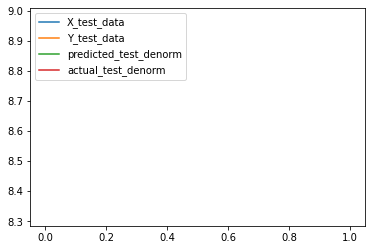

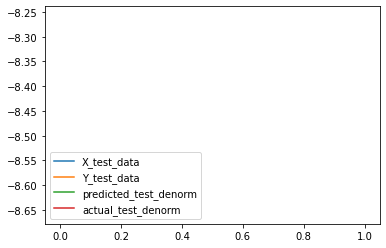

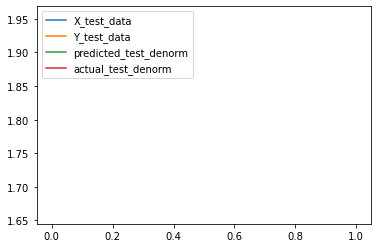

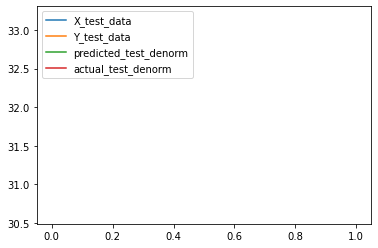

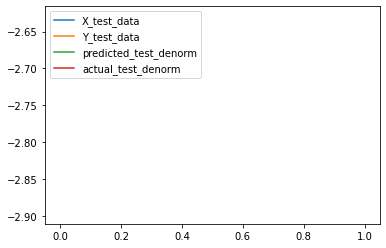

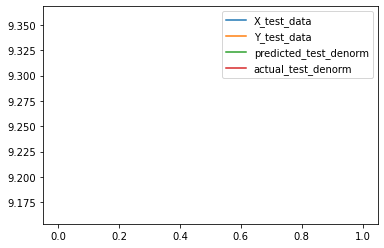

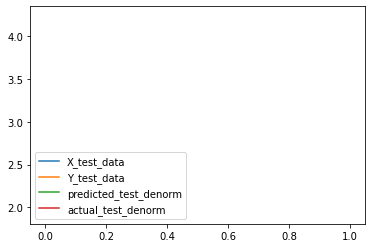

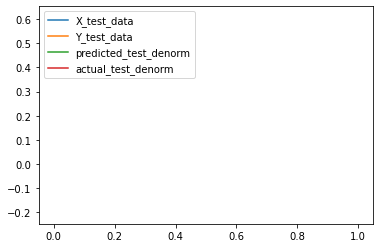

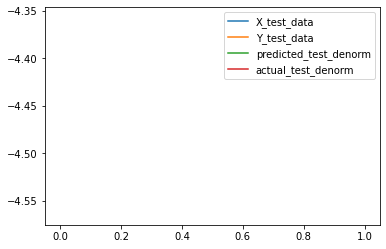

In [132]:
s=201
for f in range(len(features)):
    x = np.arange(0,input_window+output_window)
    plt.plot(x[:input_window],X_test_data[s,:,f].reshape(-1,1), label='X_test_data')
    plt.plot(x[input_window:],Y_test_data[s,:,f].reshape(-1,1), label='Y_test_data')
    plt.plot(x[input_window:],predicted_test_denorm[s,:,f].reshape(-1,1), label='predicted_test_denorm')
    plt.plot(x[input_window:], actual_test_denorm[s,:,f].reshape(-1,1), label='actual_test_denorm')
    plt.legend()
    plt.show()

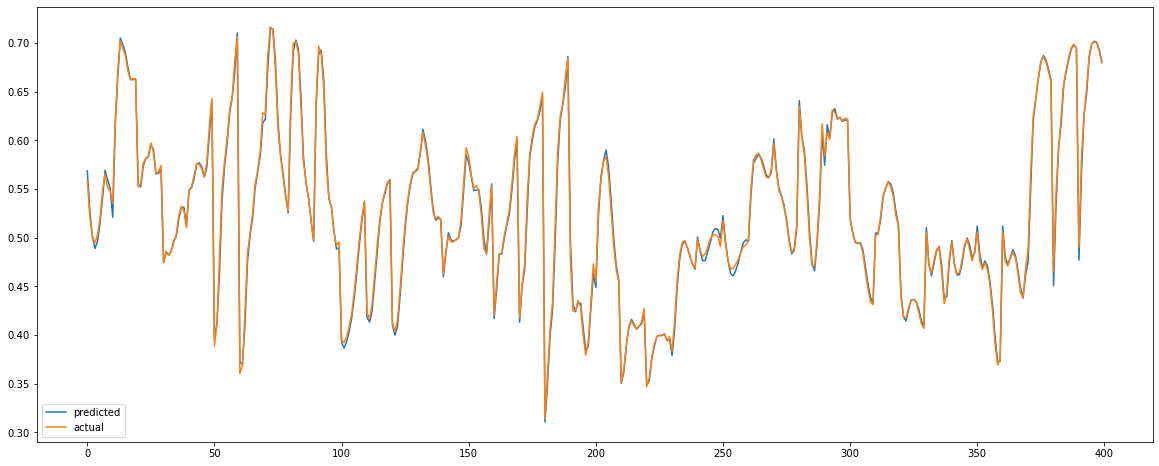

In [133]:
plt.figure(figsize=(20,8))
plt.plot(predicted_values_test[100:500,:,1].reshape(-1,1), label = 'predicted')
plt.plot(actual_values_test[100:500,:,1].reshape(-1,1), label = 'actual')
plt.legend()


In [161]:
test_mse_loss, test_mse_std = mse_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')
test_mae_loss, test_mae_std = mae_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')

print(f'Test MSE Loss: {test_mse_loss}')
print(f'Test MSE std: {test_mse_std} ')

# MDE= mae_loss(actual_test_denorm[:-1,:,:],actual_test_denorm[1:,:,:],reduction='mean', format='np')
MDE= mae_loss(actual_test_denorm[:,:,:],actual_test_denorm[:,:,:],reduction='mean', format='np')

print(f'Test MAE Loss: {test_mae_loss}')
print(f'Test MAE std: {test_mae_std}')

Test MSE Loss: 0.4511622460026649
Test MSE std: 1.5872745513916016 
Test MAE Loss: 0.45489635960285735
Test MAE std: 0.49419793486595154


In [162]:
MDE

(0.0, 0.0)

In [135]:
# ###trying bootstraping 
# diff = np.abs(predicted_test_denorm - actual_test_denorm).reshape(-1,1).squeeze()

# # calculated_mae = np.mean(diff.reshape(-1,1))
# # scipy.stats.bootstrap(diff, np.std, n_resamples=2)

# boot_means = []
# for _ in tqdm(range(200)):
#     bootsample = np.random.choice(diff,size=diff.shape, replace=True)
#     boot_means.append(bootsample.std())

# boot_means_array = np.array(boot_means)

# boot_means_array.mean()
# # boot_means_array.std()

# # plt.hist(boot_means_array, bins=100)
# # diff.std()

In [ ]:
# print(boot_means_array.std())

# test_mae_std / np.sqrt(diff.shape)

In [136]:
#Calculate the mse error for each of the features individually 
mae_feature_test = []
for f in range(len(features)):
    _ = mae_loss(np.expand_dims(predicted_test_denorm[:,:,f],-1), 
                    np.expand_dims(actual_test_denorm[:,:,f],-1), 
                    reduction='mean', 
                    format='np')
                    
    mae_feature_test.append(_)
    print(f'MAE loss for feature {f} corresponding to {features[f]} is: {mae_feature_test[f]}')

MAE loss for feature 0 corresponding to hip_angle_yaw_T is: (0.42002476864382077, 0.41703945)
MAE loss for feature 1 corresponding to hip_angle_pitch_T is: (0.2599034400243588, 0.28542644)
MAE loss for feature 2 corresponding to hip_angle_roll_T is: (0.4365956224496169, 0.43264887)
MAE loss for feature 3 corresponding to knee_angle_yaw_T is: (0.7842798811209194, 0.70247555)
MAE loss for feature 4 corresponding to knee_angle_pitch_T is: (0.29125361738007993, 0.37340623)
MAE loss for feature 5 corresponding to knee_angle_roll_T is: (0.4244955186125916, 0.4228611)
MAE loss for feature 6 corresponding to ankle_angle_yaw_T is: (0.5188330826324118, 0.56158364)
MAE loss for feature 7 corresponding to ankle_angle_pitch_T is: (0.4641974035538807, 0.46542346)
MAE loss for feature 8 corresponding to ankle_angle_roll_T is: (0.49448359296927047, 0.47988218)


In [137]:
#Calculate the mse error for each of the features individually 
mse_feature_test = []
for f in range(len(features)):
    _ = mse_loss(np.expand_dims(predicted_test_denorm[:,:,f],-1), 
                    np.expand_dims(actual_test_denorm[:,:,f],-1), 
                    reduction='mean', 
                    format='np')
                    
    mse_feature_test.append(_)
    print(f'MSE loss for feature {f} corresponding to {features[f]} is: {mse_feature_test[f]}')

MSE loss for feature 0 corresponding to hip_angle_yaw_T is: (0.3503426751957029, 1.1527689)
MSE loss for feature 1 corresponding to hip_angle_pitch_T is: (0.14901805371939542, 0.55479383)
MSE loss for feature 2 corresponding to hip_angle_roll_T is: (0.3778008020694537, 0.88164276)
MSE loss for feature 3 corresponding to knee_angle_yaw_T is: (1.1085669449533644, 2.0607781)
MSE loss for feature 4 corresponding to knee_angle_pitch_T is: (0.2242608605981429, 0.98438185)
MSE loss for feature 5 corresponding to knee_angle_roll_T is: (0.35900795953739173, 0.91704494)
MSE loss for feature 6 corresponding to ankle_angle_yaw_T is: (0.5845639365423051, 1.8693432)
MSE loss for feature 7 corresponding to ankle_angle_pitch_T is: (0.43209819755579615, 2.690192)
MSE loss for feature 8 corresponding to ankle_angle_roll_T is: (0.47480094650441373, 1.6896518)


In [ ]:
# ## investigate location of error 
# predicted_test_denorm[:,:,1] - actual_test_denorm[:,:,2]

#### Performance on test set plots

In [138]:
connected_preds=connect_arrays(predicted_test_denorm[1000:2000,:,:],len(features))
connected_targets=connect_arrays(actual_test_denorm[1000:2000,:,:],len(features))

In [139]:
# diff = predicted_test_denorm - actual_test_denorm
# for f in range(len(features)):
#     plt.figure(figsize=(20,10))
#     plt.hist(diff[:,:,f].reshape(-1,1), bins = 40, range = (-7.5,7.5))
#     # plt.hist(diff[:,:,f].reshape(-1,1), bins = 20)
#     plt.show()

# diff.min()
# diff.max()



#### Training and validating LSTM

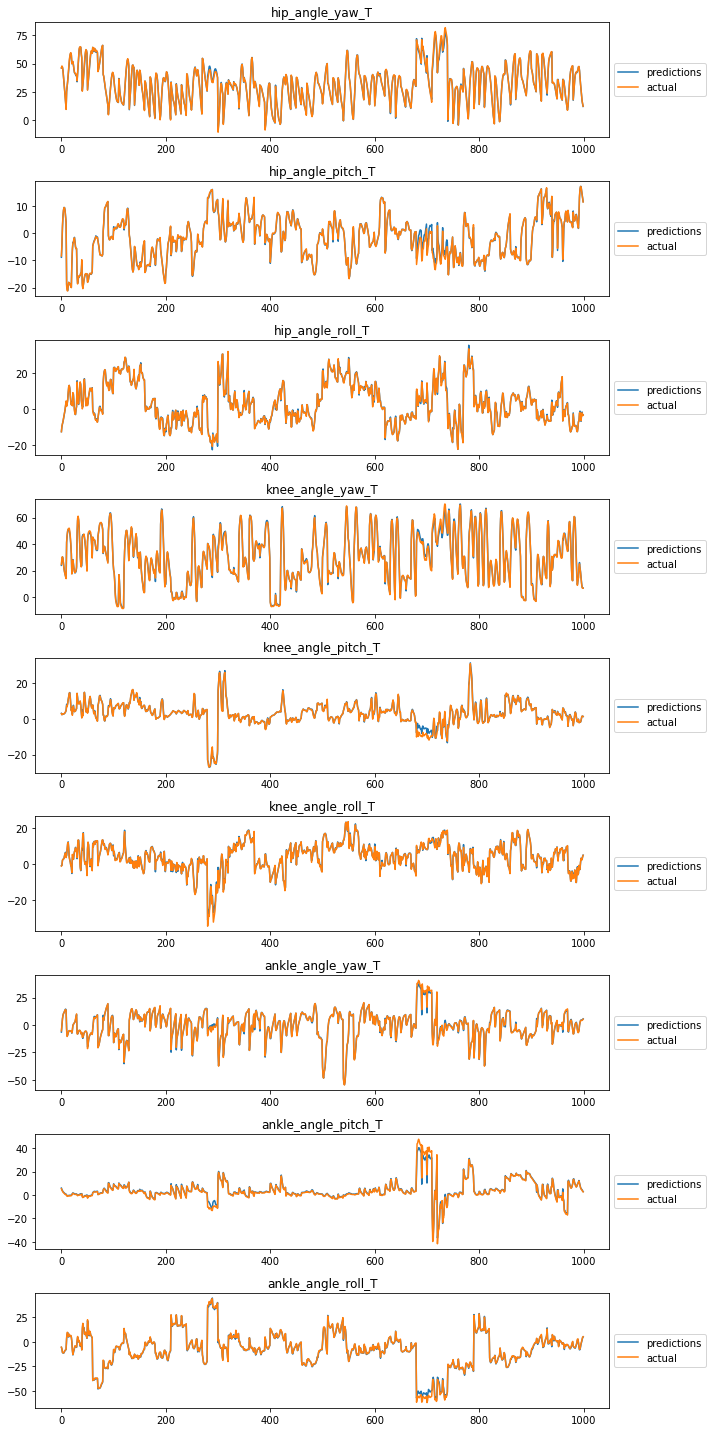

In [140]:
plot_angles_but_cooler(connected_preds,connected_targets,len(features))

Timestep ranges:10196:10216
Timestep ranges:4714:4734
Timestep ranges:8527:8547
Timestep ranges:9040:9060
Timestep ranges:6462:6482
Timestep ranges:5401:5421


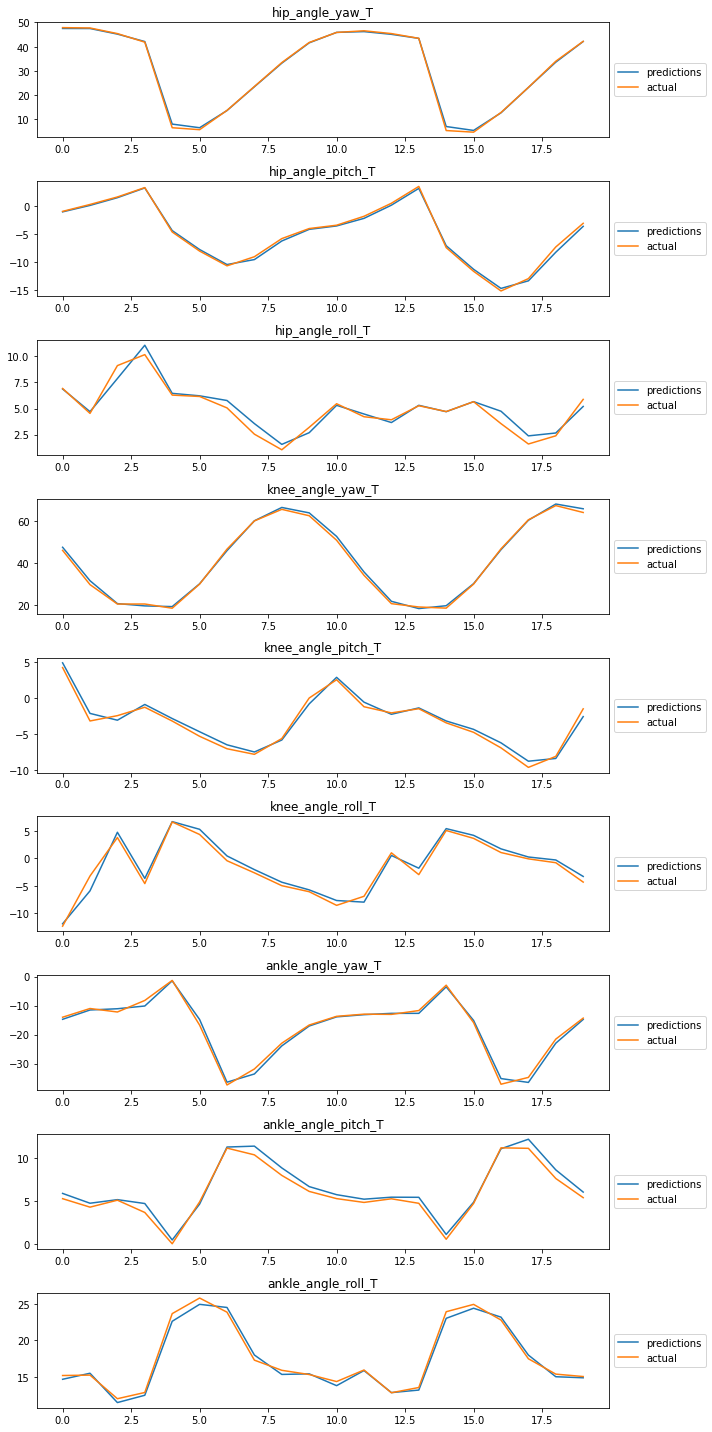

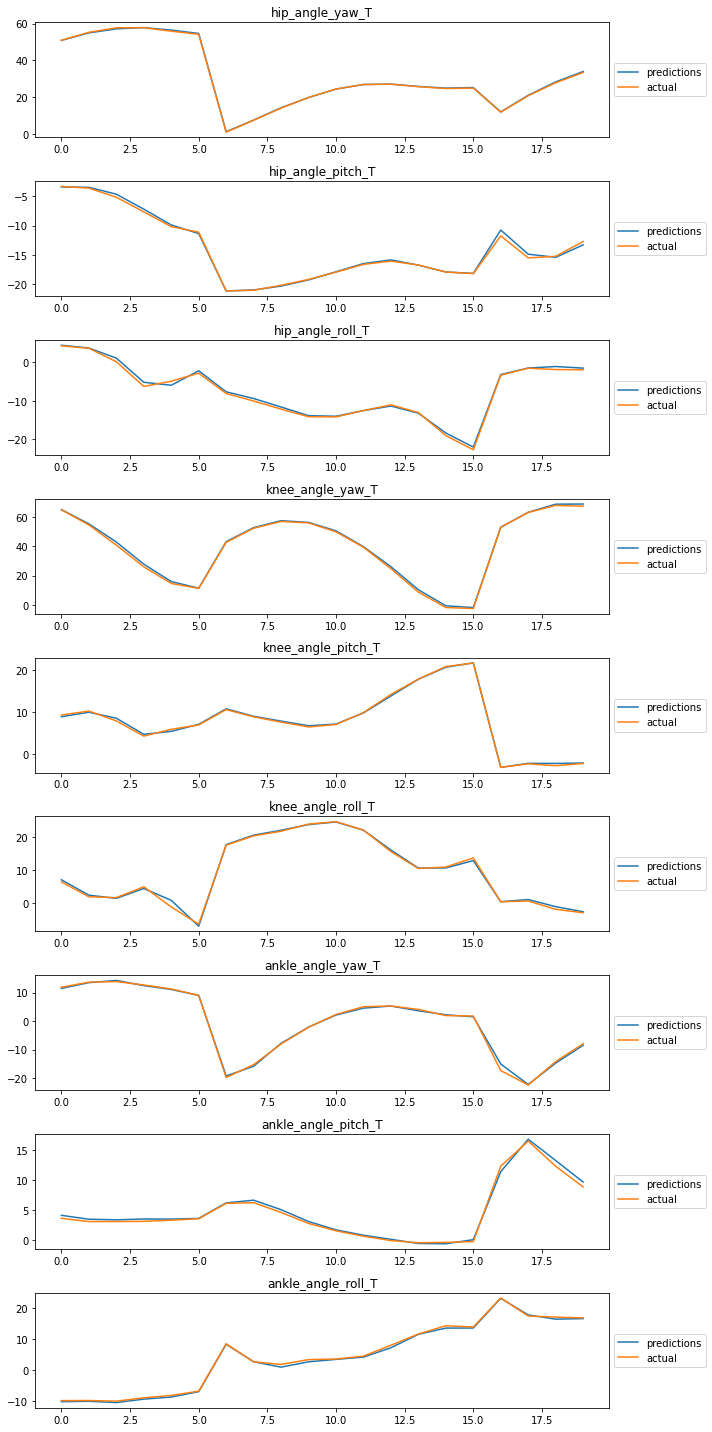

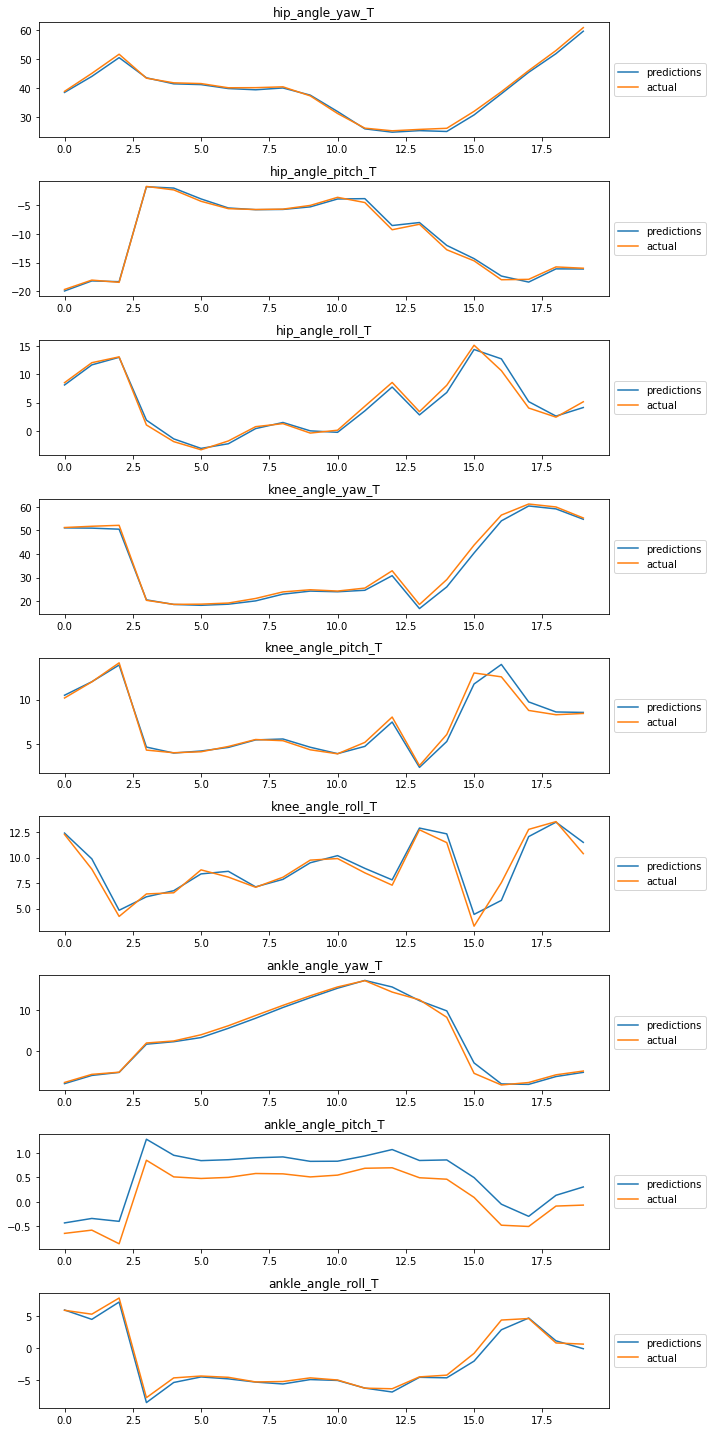

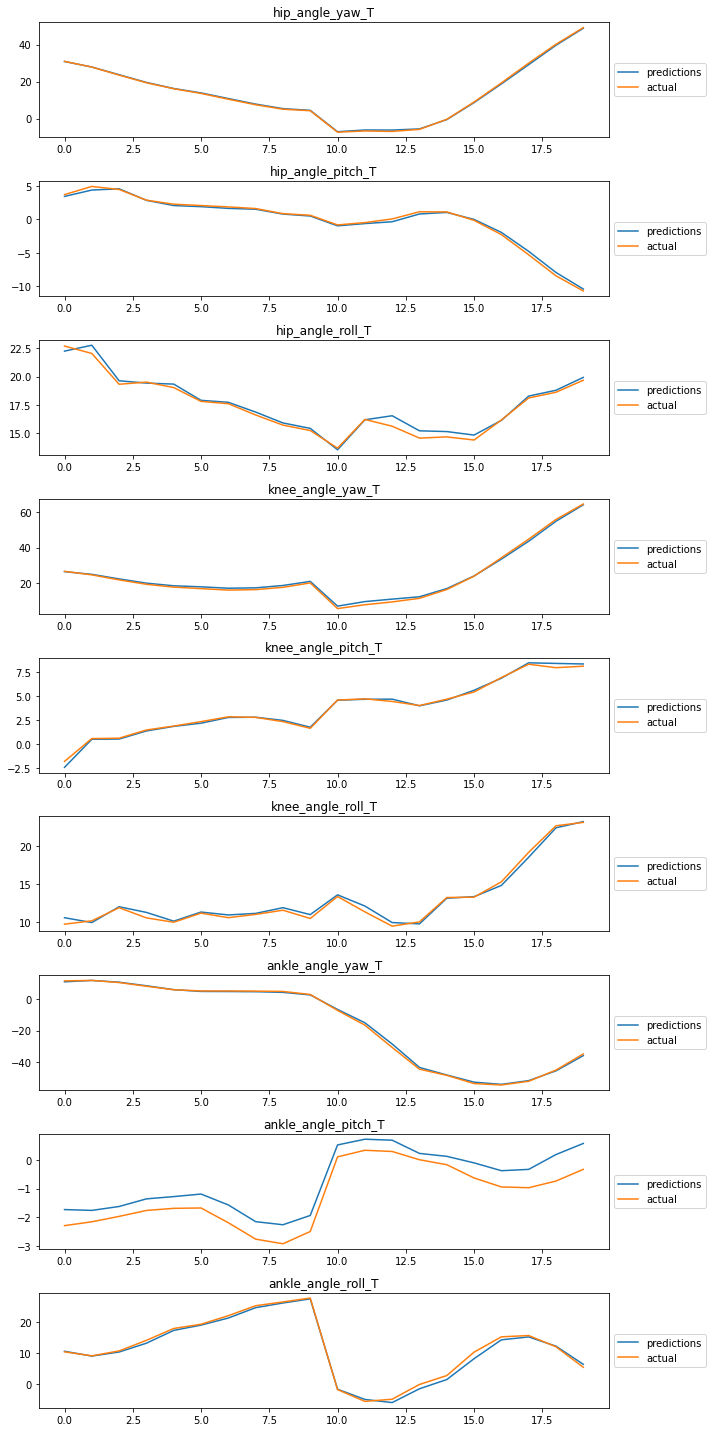

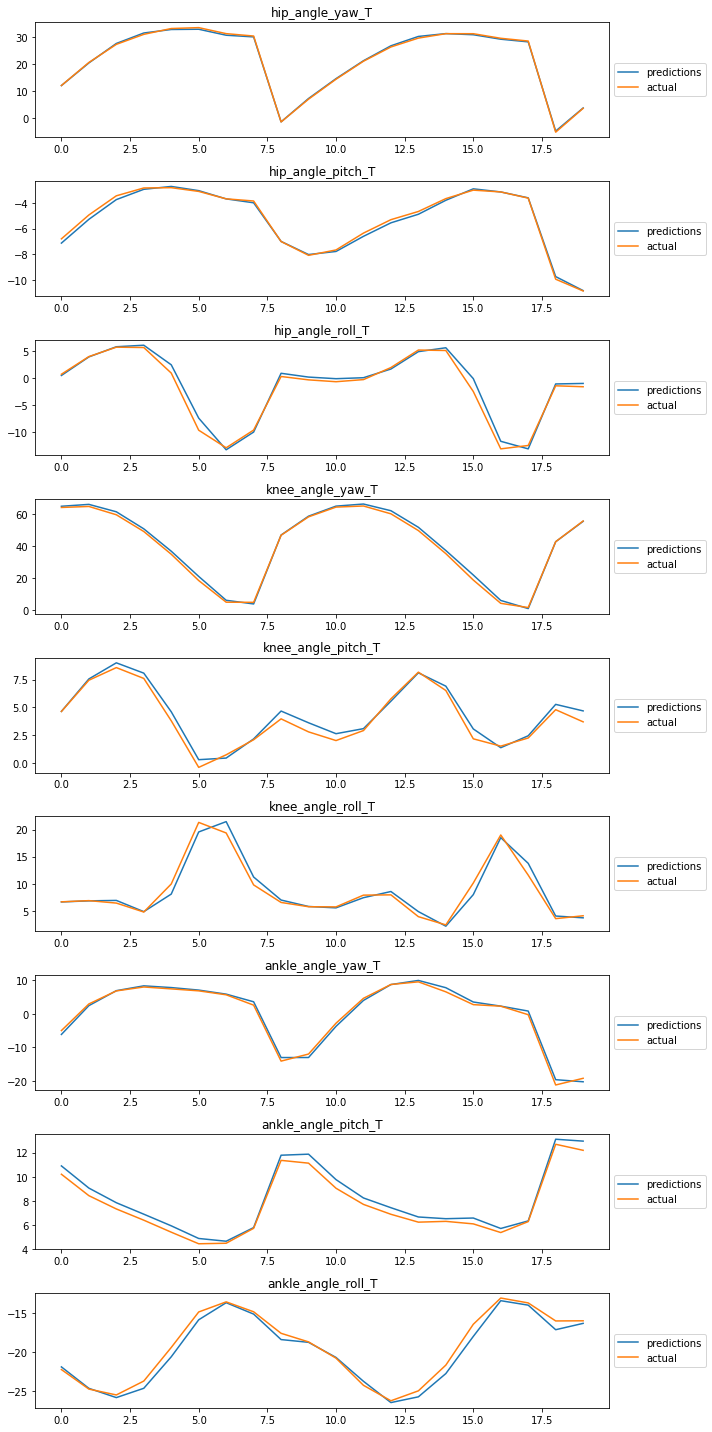

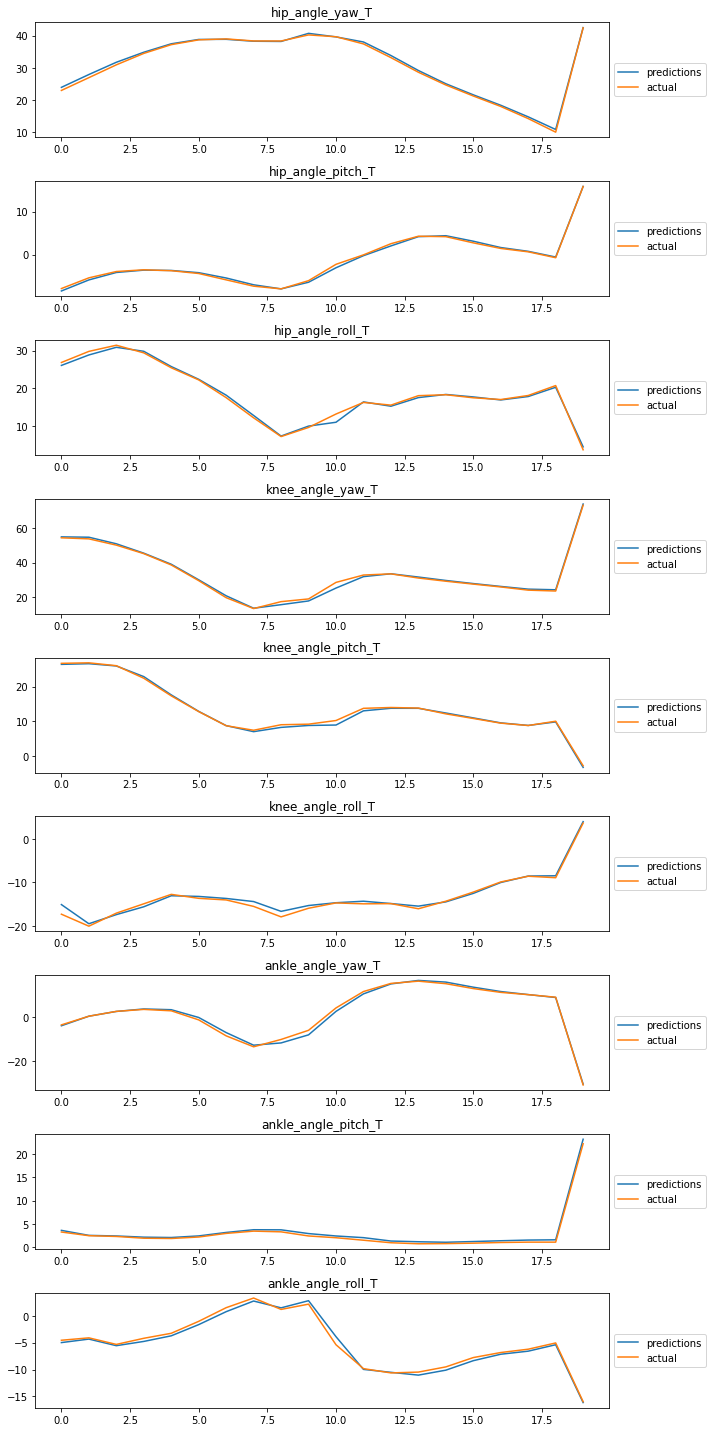

In [141]:
# Plot several random output examples
plt_width = 20 #number of time steps to plot
start_step = np.random.randint(0, high=(predicted_test_denorm.shape[0]-plt_width),size=6) #chooses random starting index to plot random samples

for i in start_step:
    print(f'Timestep ranges:{i}:{i+plt_width}')
    connected_preds=connect_arrays(predicted_test_denorm[i:i+plt_width,:,:],len(features))
    connected_targets=connect_arrays(actual_test_denorm[i:i+plt_width,:,:],len(features))
    plot_angles_but_cooler(connected_preds,connected_targets, len(features))
    plt.plot()
    

In [ ]:
def plot_angles(predictions,actual_data,features=1,batch = 10,skip=100,concat= False):
    '''
    features: number of predicting angle (integer)
    batch: number of samples to plot(int)
    skip: batches stride (int)
    concat: concatenate all the predictions in for each angle 
     '''

    # plt.figure()
    plt.figure(figsize=(10,5))
    S= predictions.shape
    print(S)
    # size of the subplots: batch x features
    if concat:
        prd = predictions.reshape(-1,S[2])
        print(prd.shape)
        act = actual_data.reshape(-1,S[2])
        for f in range(features):
            plt.subplot(1,features,(f+1))
            plt.plot(prd[:batch,f],label='prediction')
            plt.plot(act[:batch,f],label='original data')
            #plt.ylim([-10,10])
            plt.legend()
            plt.title("Output predictions on test data")
            plt.show()   
    else:
        for f in range(features):
            # might want to randomise this
            for b in range(batch):
                plt.subplot(batch,features,(f+1)*(b+1))
                plt.plot(predictions[b*skip,:,f],label='prediction')
                plt.plot(actual_data[b*skip,:,f],label='original data')
                # plt.ylim([-50,50])
                plt.title(f'Plot of feature: {f}, sample {b*skip} ')
                plt.legend()
                plt.show()   

In [ ]:
plot_angles(predicted_values_test[300:500],actual_values_test[300:500],features=1, batch = -1,concat=True)

In [ ]:
plot_angles(predicted_values_test,actual_values_test, features=len(features), batch = 2,concat=False)


### Calculate Covariance (Pearson Correlation Coefficient)

In [ ]:
covariances = []
correlations = []

for f in range(len(features)):
    X = np.stack((predicted_test_denorm[:,:,f].reshape(-1,1), actual_test_denorm[:,:,f].reshape(-1,1)), axis=0).squeeze()
    # print(X.shape)
    cov = np.cov(X)
    covariances.append(cov[0][1]) # X = (m,n) m: variable, n: column is observation of the variable

    p_std = np.std(predicted_test_denorm[:,:,f].reshape(-1,1)) #predicted standard deviation 
    t_std = np.std(actual_test_denorm[:,:,f].reshape(-1,1)) #target standard deviation

    correlations.append(cov[0][1] / (p_std*t_std))

print(covariances)
print(correlations)

mean_correlation = np.mean(correlations)
print(mean_correlation)

In [ ]:
for i in range(len(features)):
    print(f'{features[i]} covariance: {covariances[i]} | correlation: {correlations[i]}')

In [ ]:
# import statsmodels.api as sm
# # a = np.array([1,4,6,4,3,4,5,5,3,2,2])
# # b=np.array([2,3,1,3,4,3,2,2,3,3,3])

# # plt.axis([-40,40,-10,10])
# f, ax = plt.subplots(1, figsize=(8,5)) # for multiple plots
# sm.graphics.mean_diff_plot(actual_test_denorm[:,:,1].reshape(-1,1).squeeze(), predicted_test_denorm[:,:,1].reshape(-1,1).squeeze(), ax = ax)

# # sm.graphics.mean_diff_plot(a, b, ax = ax)
# plt.show()





### Calculate R2 (Coefficient of Determination)

In [ ]:
r_squares = []
for f in range(len(features)):
    
    ss_res = np.sum((actual_test_denorm[:,:,f].reshape(-1,1) - predicted_test_denorm[:,:,f].reshape(-1,1)) ** 2)
    ss_tot = np.sum((actual_test_denorm[:,:,f].reshape(-1,1) - np.mean(actual_test_denorm[:,:,f].reshape(-1,1))) ** 2)

    r_squared = 1 - (ss_res/ss_tot)

    r_squares.append(r_squared)

mean_r_sqaured = np.mean(r_squares)
print(r_squares)
print(mean_r_sqaured)

In [ ]:
for i in range(len(features)):
    print(f'{features[i]} r_sqaured: {r_squares[i]}')

### Plots for paper

In [ ]:
# ## Plot of distribution of error 
# mae_diff = (np.abs(predicted_test_denorm[:,:,:] - actual_test_denorm[:,:,:])).reshape(-1,1).squeeze()
# print(f'mae_diff size: {mae_diff.shape[0]}') 

# mae_diff_mean = np.sum(mae_diff)/mae_diff.shape[0] 
# print(f'mae loss mean: {mae_diff_mean}')

# print(f'minimum loss: {mae_diff.min()}')
# print(f'maximum loss: {mae_diff.max()}')
# print(f'maximum loss corresponds to (angle): {mae_diff.max()}')


# auto_mae_std = np.std(mae_diff)
# print(f'Automatic MAE std: {auto_mae_std}')

# manual_mae_std = np.sqrt((1/mae_diff.shape[0]) * np.sum((mae_diff-test_mae_loss) ** 2))

# # manual_mae_std = (1/mae_diff.shape[0]) * np.sum(np.abs(mae_diff-test_mae_loss))
# print(f'Manual MAE std: {manual_mae_std}')

# plt.figure(figsize=(10,5))
# # plt.hist(mae_diff, bins=200, range=(0,mae_diff.max()))
# plt.hist(mae_diff, bins=100, range=(0,4), facecolor='tab:blue')
# plt.vlines(x=mae_diff_mean, ymin=0, ymax=100000, linestyles ="dashed", colors ="r", linewidth=2, label='MAE = ' + '{:.4f}'.format(mae_diff_mean))
# plt.vlines(x=auto_mae_std, ymin=0, ymax=100000, linestyles ="dotted", colors ="g", linewidth=2, label='MAE Standard Deviation = ' + '{:.4f}'.format(auto_mae_std))
# plt.title('Distribution of Mean Absolute Errors (bins=100)')
# plt.xlabel('Error (degrees)')
# plt.ylabel('Frequency (Number of Samples)')
# plt.legend()

# mae_diff.shape[0]

# threshold = 2
# larger_than_mean = np.where(mae_diff>threshold)
# print(f'number of points larger than mean: {len(larger_than_mean[0])}')

# print(f'threshold: {threshold}')
# percentage = len(larger_than_mean[0])/mae_diff.shape[0] *100
# # print(f'percentage of values above the threshold: {percentage}')

In [ ]:
# ## Plot of distribution of error 
# mae_diff = ((predicted_test_denorm[:,:,:] - actual_test_denorm[:,:,:])).reshape(-1,1).squeeze()
# print(f'mae_diff size: {mae_diff.shape[0]}') 

# mae_diff_mean = np.sum(mae_diff)/mae_diff.shape[0] 
# print(f'mae loss mean: {mae_diff_mean}')

# print(f'minimum loss: {mae_diff.min()}')
# print(f'maximum loss: {mae_diff.max()}')
# print(f'maximum loss corresponds to (angle): {mae_diff.max()}')


# auto_mae_std = np.std(mae_diff)
# print(f'Automatic MAE std: {auto_mae_std}')

# manual_mae_std = np.sqrt((1/mae_diff.shape[0]) * np.sum((mae_diff-test_mae_loss) ** 2))

# # manual_mae_std = np.sqrt((1/mae_diff.shape[0]) * np.sum((mae_diff-test_mae_loss) ** 2))

# # manual_mae_std = (1/mae_diff.shape[0]) * np.sum(np.abs(mae_diff-test_mae_loss))
# print(f'Manual MAE std: {manual_mae_std}')

# plt.figure(figsize=(10,5))
# # plt.hist(mae_diff, bins=200, range=(0,mae_diff.max()))
# plt.hist(mae_diff, bins=200, range=(-3.5,3.5), facecolor='tab:blue')
# # plt.vlines(x=mae_diff_mean, ymin=0, ymax=20000, linestyles ="dashed", colors ="r", linewidth=2, label='MAE = ' + '{:.4f}'.format(mae_diff_mean))
# # plt.vlines(x=auto_mae_std, ymin=0, ymax=20000, linestyles ="dotted", colors ="g", linewidth=2, label='MAE Standard Deviation = ' + '{:.4f}'.format(auto_mae_std))
# plt.title('Distribution of Mean Errors (bins=100)')
# plt.xlabel('Error (degrees)')
# plt.ylabel('Frequency (Number of Samples)')
# plt.legend()

# mae_diff.shape[0]

# threshold = 2
# larger_than_mean = np.where(mae_diff>threshold)
# print(f'number of points larger than mean: {len(larger_than_mean[0])}')

# print(f'threshold: {threshold}')
# percentage = len(larger_than_mean[0])/mae_diff.shape[0] *100
# # print(f'percentage of values above the threshold: {percentage}')

In [122]:
# Loss for each indiividual timestep
# mse_feature_test = []
# for f in range(len(features)):
#     _ = mse_loss(np.expand_dims(predicted_test_denorm[:,:,f],-1), 
#                     np.expand_dims(actual_test_denorm[:,:,f],-1), 
#                     reduction='mean', 
#                     format='np')
                    
#     mse_feature_test.append(_)
#     print(f'MSE loss for feature {f} corresponding to {features[f]} is: {mse_feature_test[f]}')

mae_timesteps = []
for s in range(output_window):
    # print(s)
    _ = mae_loss(np.expand_dims(predicted_test_denorm[:,s,:],-1), np.expand_dims(actual_test_denorm[:,s,:],-1), reduction='mean', format='np')
    mae_timesteps.append(_)

    print(f'MAE loss and standard deviation for timestep {s+1} is: {mae_timesteps[s]}')

predicted_test_denorm[:,:,:].shape




NameError: name 'predicted_test_denorm' is not defined

In [123]:
hip_mae, hip_mae_std =  mae_loss(predicted_test_denorm[:,:,0:3], actual_test_denorm[:,:,0:3], reduction='mean', format='np')
knee_mae, knee_mae_std =  mae_loss(predicted_test_denorm[:,:,3:6], actual_test_denorm[:,:,3:6], reduction='mean', format='np')
ankle_mae, ankle_mae_std =  mae_loss(predicted_test_denorm[:,:,6:9], actual_test_denorm[:,:,6:9], reduction='mean', format='np')

print(f'hip MAE and std: {hip_mae}, {hip_mae_std}')
print(f'knee MAE and std: {knee_mae}, {knee_mae_std}')
print(f'ankle MAE and std: {ankle_mae}, {ankle_mae_std}')

NameError: name 'predicted_test_denorm' is not defined

In [ ]:
print('loss')
for i in mae_timesteps:
    print(i[0])

print('loss std')
for i in mae_timesteps:
    print(i[1])

print('joint')
print(hip_mae)
print(knee_mae)
print(ankle_mae)

print('joint std')
print(hip_mae_std)
print(knee_mae_std)
print(ankle_mae_std)

### T-tests

In [131]:
import_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Models\MLP_1' + '\\' + 'Exp010-2022-03-10-MLP-In120-Out24.pickle'

# hidden_size=128
# num_layers=4
# model_LSTM = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, in_seq_len=in_seq_len, out_seq_len=out_seq_len, output_size=output_size, device=DEVICE).to(DEVICE)
# model_LSTM.load_state_dict(torch.load(import_path))
# model_LSTM.eval()


# model_CNN = CNN(input_size, output_size=output_size, in_seq_len=in_seq_len, out_seq_len=out_seq_len,  device = DEVICE).to(DEVICE)
# model_CNN.load_state_dict(torch.load(import_path))
# model_CNN.eval()


model_MLP = MLP(input_size=input_size, in_seq_len=in_seq_len, out_seq_len=out_seq_len, output_size=output_size, device=DEVICE).to(DEVICE)
model_MLP.load_state_dict(torch.load(import_path))
model_MLP.eval()


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (MLP): Sequential(
    (0): Linear(in_features=1080, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): ReLU()
    (8): Linear(in_features=200, out_features=216, bias=True)
  )
)

In [129]:
lstm_pred_test_output, lstm_actual_test_output, test_loss = test_LSTM(model_LSTM, test_dataloader)

lstm_predicted_values_test = lstm_pred_test_output.cpu().numpy() # premute again to make the order of the array (samples, windows, features)
lstm_actual_values_test =  lstm_actual_test_output.cpu().numpy()

print(f'test loss: {test_loss}')

print(f'Shape of predicted values test: {lstm_predicted_values_test.shape}')
print(f'shape of actual values test: {lstm_actual_values_test.shape}')

lstm_predicted_test_denorm = denormalise(lstm_predicted_values_test, scalars)
lstm_actual_test_denorm =  denormalise(lstm_actual_values_test, scalars)

print(f'Shape of predicted values test post denormalisation: {lstm_predicted_test_denorm.shape}')
print(f'shape of actual values test post denormalisation: {lstm_actual_test_denorm.shape}')

0it [00:00, ?it/s]

test loss: 0.0006174283865665859
Shape of predicted values test: (15010, 24, 9)
shape of actual values test: (15010, 24, 9)
Shape of predicted values test post denormalisation: (15010, 24, 9)
shape of actual values test post denormalisation: (15010, 24, 9)


In [133]:
# lstm_mse_loss, lstm_mse_std = mse_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')
lstm_mae_loss, lstm_mae_std = mae_loss(lstm_predicted_test_denorm, lstm_actual_test_denorm, reduction='mean', format='np')

# print(f'Test MSE Loss: {test_mse_loss}')
# print(f'Test MSE std: {test_mse_std} ')
print(f'Test MAE Loss: {lstm_mae_loss}')
print(f'Test MAE std: {lstm_mae_std}')

Test MAE Loss: 1.827607366693809
Test MAE std: 2.37290620803833


In [125]:
cnn_pred_test_output, cnn_actual_test_output, test_loss = test_CNN(model_CNN, test_dataloader)

cnn_predicted_values_test = cnn_pred_test_output.cpu().numpy() # premute again to make the order of the array (samples, windows, features)
cnn_actual_values_test =  cnn_actual_test_output.cpu().numpy()

print(f'test loss: {test_loss}')

print(f'Shape of predicted values test: {cnn_predicted_values_test.shape}')
print(f'shape of actual values test: {cnn_actual_values_test.shape}')

cnn_predicted_test_denorm = denormalise(cnn_predicted_values_test, scalars)
cnn_actual_test_denorm =  denormalise(cnn_actual_values_test, scalars)

print(f'Shape of predicted values test post denormalisation: {cnn_predicted_test_denorm.shape}')
print(f'shape of actual values test post denormalisation: {cnn_actual_test_denorm.shape}')

0it [00:00, ?it/s]

test loss: 0.001232033726410009
Shape of predicted values test: (15010, 24, 9)
shape of actual values test: (15010, 24, 9)
Shape of predicted values test post denormalisation: (15010, 24, 9)
shape of actual values test post denormalisation: (15010, 24, 9)


In [134]:
# lstm_mse_loss, lstm_mse_std = mse_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')
cnn_mae_loss, cnn_mae_std = mae_loss(cnn_predicted_test_denorm, cnn_actual_test_denorm, reduction='mean', format='np')

# print(f'Test MSE Loss: {test_mse_loss}')
# print(f'Test MSE std: {test_mse_std} ')
print(f'Test MAE Loss: {cnn_mae_loss}')
print(f'Test MAE std: {cnn_mae_std}')

Test MAE Loss: 2.738398166654329
Test MAE std: 3.2416164875030518


In [137]:
mlp_pred_test_output, mlp_actual_test_output, test_loss = test_MLP(model_MLP, test_dataloader)

mlp_predicted_values_test = mlp_pred_test_output.cpu().numpy() # premute again to make the order of the array (samples, windows, features)
mlp_actual_values_test =  mlp_actual_test_output.cpu().numpy()

print(f'test loss: {test_loss}')

print(f'Shape of predicted values test: {mlp_predicted_values_test.shape}')
print(f'shape of actual values test: {mlp_actual_values_test.shape}')

mlp_predicted_test_denorm = denormalise(mlp_predicted_values_test, scalars)
mlp_actual_test_denorm =  denormalise(mlp_actual_values_test, scalars)

print(f'Shape of predicted values test post denormalisation: {mlp_predicted_test_denorm.shape}')
print(f'shape of actual values test post denormalisation: {mlp_actual_test_denorm.shape}')

0it [00:00, ?it/s]

test loss: 0.000813357602430884
Shape of predicted values test: (15010, 24, 9)
shape of actual values test: (15010, 24, 9)
Shape of predicted values test post denormalisation: (15010, 24, 9)
shape of actual values test post denormalisation: (15010, 24, 9)


In [139]:
# lstm_mse_loss, lstm_mse_std = mse_loss(predicted_test_denorm, actual_test_denorm, reduction='mean', format='np')
mlp_mae_loss, mlp_mae_std = mae_loss(mlp_predicted_test_denorm, mlp_actual_test_denorm, reduction='mean', format='np')

# print(f'Test MSE Loss: {test_mse_loss}')
# print(f'Test MSE std: {test_mse_std} ')
print(f'Test MAE Loss: {mlp_mae_loss}')
print(f'Test MAE std: {mlp_mae_std}')

Test MAE Loss: 2.3203716041157745
Test MAE std: 2.5535826683044434


In [140]:
## benchmark against mean output

naive_average_test_output = np.zeros(Y_test_data.shape)

for f in range(len(features)):
    for s in range(Y_test_data.shape[0]):
        naive_average_test_output[s,:,f] = np.ones((output_window)) * np.mean(X_test_data[s,:,f])



print(naive_average_test_output.shape)



(15010, 24, 9)


In [141]:
naive_average_mse_loss, naive_average_mse_std = mse_loss(naive_average_test_output, Y_test_data, reduction='mean', format='np')
naive_average_mae_loss, naive_average_mae_std = mae_loss(naive_average_test_output, Y_test_data, reduction='mean', format='np')

# print(f'average MSE Loss: {naive_average_mse_loss}')
# print(f'average MSE std: {naive_average_mse_std} ')
print(f'average MAE Loss: {naive_average_mae_loss}')
print(f'average MAE std: {naive_average_mae_std}')

average MAE Loss: 6.385477375258885
average MAE std: 7.217397533502615


In [142]:
## benchmark against naive output (making predictino only last value)


naive_1_test_output = np.zeros(Y_test_data.shape)

for f in range(len(features)):
    for s in range(Y_test_data.shape[0]):
        naive_1_test_output[s,:,f] = np.ones((output_window)) * X_test_data[s,-1,f]



# print(naive_1_test_output.shape)


# naive_1_test_output[1,:,1]

# X_test_data[1,:,1]



In [143]:
naive_1_mse_loss, naive_1_mse_std = mse_loss(naive_1_test_output, Y_test_data, reduction='mean', format='np')
naive_1_mae_loss, naive_1_mae_std = mae_loss(naive_1_test_output, Y_test_data, reduction='mean', format='np')

# print(f'naive_1 MSE Loss: {naive_1_mse_loss}')
# print(f'naive_1 MSE std: {naive_1_mse_std} ')
print(f'naive_1 MAE Loss: {naive_1_mae_loss}')
print(f'naive_1 MAE std: {naive_1_mae_std}')

naive_1 MAE Loss: 4.448045226258659
naive_1 MAE std: 6.303550725173938


In [151]:
#t-tests
lstm_diff = np.abs(lstm_predicted_test_denorm -lstm_actual_test_denorm).reshape(-1,1).squeeze()

cnn_diff = np.abs(cnn_predicted_test_denorm -cnn_actual_test_denorm).reshape(-1,1).squeeze()

mlp_diff = np.abs(mlp_predicted_test_denorm -mlp_actual_test_denorm).reshape(-1,1).squeeze()

naive_1_diff = np.abs(naive_1_test_output - Y_test_data).reshape(-1,1).squeeze()

naive_avrg_diff = np.abs(naive_average_test_output - Y_test_data).reshape(-1,1).squeeze()


stats.ttest_rel(naive_avrg_diff, lstm_diff)

Ttest_relResult(statistic=1155.3242230360363, pvalue=0.0)

In [145]:
naive_1_array = np.array(naive_1_test_output)

naive_1_diff = np.abs(naive_1_array - Y_test_data).reshape(-1,1).squeeze()



### Saving Results

#### Selecting file name and location 

In [ ]:
model = 'MLP'
exp_ID = '010'

# out_fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_1' + '\\' + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '.txt'
# out_fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_2' + '\\' + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '.txt'
# out_fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results' + '\\' + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '.txt'
out_fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\MLP_1' + '\\' + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '.txt'
# out_fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\CNN_1' + '\\' + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '.txt'



out_fname

In [ ]:
changes = 'Ran' + str(model)+ 'model with 6 features, ' + str(input_window)+  ' input and ' + str(output_window) + ' outputs. Fixed window samples (10 per each trial), epoch is 60 and optimiser is MSE. Batch size 32.'
comments = 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + ': ' + changes + '|' + 'test MAE loss: ' + str(round(test_mae_loss, 3)) + ' ' +'std: ' + str(round(test_mae_std,3))
comments

In [ ]:
# fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_1' + '\\' + 'LSTM Experiment Results.txt'
# fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_2' + '\\' + 'LSTM_2 Experiment Results.txt'
# fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results' + '\\' + 'Experiments.txt'
# fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_4' + '\\' + 'LSTM_4 Experiment Results.txt'
fname = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\MLP_1' + '\\' + 'MLP_1 Experiment Results.txt'


with open(fname, 'a+') as text_file:
    text_file.write('\n')
    text_file.write(comments)



In [ ]:
os.path.exists(out_fname)

In [ ]:
if os.path.exists(out_fname):
    print('ERROR: File with this name already exists, try alternative name.')
    
else:
    with open(out_fname, "w") as text_file:
        print('Experiment Report', file=text_file)
        print(f'date: {date.today()}',file=text_file)
        print(f'experiment ID: {exp_ID}',file=text_file)
        print('\n', file=text_file)
        print('Changes:', file=text_file)
        print(changes, file=text_file)
        print('\n', file= text_file)
        print(f'model: {model}', file=text_file)
        print(f'features: {features}', file=text_file)

        print(f'input window size: {input_window}', file=text_file)
        print(f'output window size: {output_window}', file=text_file)
        print(f'stride: {stride}', file=text_file)
    
    
        print(f'train size: {train_sample_sum}', file=text_file)
        print(f'validation size: {val_sample_sum}', file=text_file)
        print(f'test size: {test_sample_sum}', file=text_file)

        print(f'train precentage: {0.8}', file=text_file)
        print(f'validation percentage: {0.2}', file=text_file)
 
        print(f'train samples: {len(filtered_index_train_val) - len(train_excluded_samples)}', file=text_file)
        print(f'validation samples: {len(filtered_index_val)- len(val_excluded_samples)}', file=text_file) 
        print(f'test sample: {len(filtered_index_test) - len(test_excluded_samples)}', file=text_file) 
        print(f'Note: training is based on combined training and validation set.', file=text_file) 
        
        ### MLP
        print(f'epochs: {num_epochs}', file=text_file)
        print(f'learning rate: {learning_rate}', file=text_file)
        
        ## LSTM
        # print(f'epochs: {num_epochs}', file=text_file)
        # print(f'hidden size: {hidden_size}', file=text_file)
        # print(f'number of layers: {num_layers}', file=text_file)
        # print(f'learning rate: {learning_rate}', file=text_file)
        # print(f'optimiser: MSE', file=text_file)

        ## CNN
        print(f'epochs: {num_epochs}', file=text_file)
        # print(f'kernel size: {kernel_size}', file=text_file)
        print(f'learning rate: {learning_rate}', file=text_file)
        print(f'optimiser: MSE', file=text_file)

        ### Hybrid
        # print(f'epochs: {num_epochs}', file=text_file)
        # print(f'learning rate: {learning_rate}', file=text_file)
        # print(f'hidden size: {hidden_size}', file=text_file)
        # print(f'number of layers: {num_layers}', file=text_file)

        print(f'Losses during training: \n', file=text_file)
        print(f'training loss: {train_history}', file=text_file)
        # print(f'validation history: {val_history}', file=text_file)
        print(f'test loss during training: {test_loss}', file=text_file)

        print('\n', file=text_file)
        print(f'Denomralised MSE and MAE: ', file=text_file)
        print(f'Validation MSE and std(degrees): {val_mse_loss}, {val_mse_std}', file=text_file)
        print(f'Validation MAE and std (degrees): {val_mae_loss}, {val_mae_std}', file=text_file)
        print(f'Test MSE and std(degrees): {test_mse_loss}, {test_mse_std}', file=text_file)
        print(f'Test MAE and std (degrees): {test_mae_loss}, {test_mae_std}', file=text_file)
        print('\n', file=text_file)

        print(f'Loss for each feature in the validation set:', file=text_file)
        for i, f in enumerate(features):
            print(f'MSE and MAE loss and std for {f}: {mse_feature_val[i]}, {mae_feature_val[i]}', file=text_file)


        print(f'Loss for each feature in the test set:', file=text_file)
        for i, f in enumerate(features):
            print(f'MSE and MAE loss and std for {f}: {mse_feature_test[i]}, {mae_feature_test[i]}', file=text_file)

        print('\n', file=text_file)
        print(f'mean_correlation: {mean_correlation}', file=text_file)
        for i in range(len(features)):
            print(f'{features[i]} covariance: {covariances[i]} | correlation: {correlations[i]}', file=text_file)


        print('\n', file=text_file)
        print(f'mean coefficient of determination: {mean_r_sqaured}', file=text_file)
        for i in range(len(features)):
            print(f'{features[i]} r_sqaured: {r_squares[i]}', file=text_file)

        print('\n', file=text_file)
        print(f'hip MAE and std: {hip_mae}, {hip_mae_std}', file=text_file)
        print(f'knee MAE and std: {knee_mae}, {knee_mae_std}', file=text_file)
        print(f'ankle MAE and std: {ankle_mae}, {ankle_mae_std}', file=text_file)

        print('\n', file=text_file)
        print('Loss for each timestep:', file=text_file)
        for i in mae_timesteps:
            print(i[0], file=text_file)

        print('Std for each loss for each timestep:' , file=text_file)
        for i in mae_timesteps:
            print(i[1], file=text_file)


        # print('\n', file=text_file)
        # print('Naive: output is the last part of input shifted' , file=text_file)
        # print(f'Naive MSE Loss: {naive_mse_loss}', file=text_file)
        # print(f'Naive MSE std: {naive_mse_std} ', file=text_file)
        # print(f'Naive MAE Loss: {naive_mae_loss}', file=text_file)
        # print(f'Naive MAE std: {naive_mae_std}', file=text_file)

        # print('\n', file=text_file)
        # print('Naive_1: output is the last input value' , file=text_file)
        # print(f'naive_1 MSE Loss: {naive_1_mse_loss}', file=text_file)
        # print(f'naive_1 MSE std: {naive_1_mse_std} ', file=text_file)
        # print(f'naive_1 MAE Loss: {naive_1_mae_loss}', file=text_file)
        # print(f'naive_1 MAE std: {naive_1_mae_std}', file=text_file)


        # print('\n', file=text_file)
        # print('Naive_average: output is the average of input value' , file=text_file)
        # print(f'naive average MSE Loss: {naive_average_mse_loss}', file=text_file)
        # print(f'naive average MSE std: {naive_average_mse_std} ', file=text_file)
        # print(f'naive average MAE Loss: {naive_average_mae_loss}', file=text_file)
        # print(f'naive average MAE std: {naive_average_mae_std}', file=text_file)

        print('\n', file = text_file)
        print(f'Model Architecture', file=text_file)
        print(model_MLP, file=text_file)
    print("Generation of text file complete.")

#### Save loss plot

In [ ]:
# plt_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + ' (loss 2)' + '.png'
plt_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\MLP_1' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + ' (loss)' + '.png'


plt_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\MLP_1' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '(loss)' + '.png'
x = [i for i in range(20,num_epochs)]
# print(x)
# print(train_history[20:145].shape)
plt.plot(x,train_history[20:], label = 'Training loss')
plt.plot(x,val_history[20:], label = 'Val loss')
# plt.plot(train_history, label = 'Training loss')
# plt.plot(val_history, label = 'Val loss')


plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Train and Val MSE Loss')
plt.legend()
plt.savefig(plt_path)

#### Save preds plot

In [ ]:
# Plot several random output examples
# plt_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '(test preds)' + '.png'
plt_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\MLP_1' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '(test preds)' + '.png'

# plt_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Results\LSTM_4' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model + '-In' + str(input_window) + '-Out' + str(output_window) + '(test preds)' + '.png'

plt_width = 200 #number of time steps to plot
start_step = np.random.randint(0, high=(predicted_test_denorm.shape[0]-plt_width),size=1) #chooses random starting index to plot random samples

for i in start_step:
    print(f'Timestep ranges:{i}:{i+plt_width}')
    connected_preds=connect_arrays(predicted_test_denorm[i:i+plt_width,:,:],len(features))
    connected_targets=connect_arrays(actual_test_denorm[i:i+plt_width,:,:],len(features))
    plot_angles_but_cooler(connected_preds,connected_targets, len(features))
    plt.savefig(plt_path)

#### Save model and weights

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_MLP.state_dict():
    print(param_tensor, "\t", model_MLP.state_dict()[param_tensor].size())

#### Export model/weights

In [ ]:
# Export model
# export_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Models' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model+ '-In' + str(input_window) + '-Out' + str(output_window) +'.pickle'
export_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Models\MLP_1' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model+ '-In' + str(input_window) + '-Out' + str(output_window) +'.pickle'

# export_path = r'C:\Users\Rania\rbk9\Study 1 Results and Models\Study 1 Models\LSTM_4' + '\\'  + 'Exp' + str(exp_ID) + '-' + str(date.today()) + '-' + model+ '-In' + str(input_window) + '-Out' + str(output_window) +'.pickle'


export_path

In [ ]:
torch.save(model_MLP.state_dict(), export_path)

#### Import model/weights

In [ ]:
# print(model_CNN)

In [ ]:
# fname = r'C:\Users\Rania\OneDrive - University of Kent\data_pickle' + '\\' + 'alldata_test_L.pickle'

# # fname= r'D:\rbk9\data_pickle' + '\\' + 'test_data.pickle'

# with open(fname, 'rb') as handle:
#     test_data = pickle.load(handle)

# test_size = test_data.shape[0]

# print(f"Shape of test data is: {test_data.shape}")
# print(f"test_size: {test_size}")